# input

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
import numpy as np
import pandas as pd
import pypsa
import xarray as xr
import tikzplotlib
import seaborn as sns

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",  # or 'xelatex' or 'lualatex'
    "font.family": "serif",
    "text.usetex": True,  # Use LaTeX to write all text
    "pgf.rcfonts": False,  # Do not set up fonts from rc parameters
})

tech_colors = {
    "local": "#b474b4",
    "PPA": "#b474b4",
    "grid": "#9ccc65",
    "grid imports": "#9ccc65",
    "revenue": "g",
    "wind": "#74c6f2",
    "offshore wind": "#6895dd",
    "onshore wind": "#74c6f2",
    "solar": "#ffef60",
    "solar rooftop": "#000000",
    "advanced nuclear": "#df3439",
    "advanced geothermal": "#99582a",
    "advanced dispatchable": "#99582a",
    "NG-Allam": "#540b0e",
    "hydroelectricity": "#298c81",
    "nuclear": "#ff8c00",
    "battery": "#666666",
    "battery discharger": "#444444",
    "battery inverter": "#444444",
    "battery storage": "#666666",
    "hydrogen storage": "#cc00be",
    "hydrogen fuel cell": "#990090",
    "hydrogen electrolysis": "#550055",
    "pumped hydro storage": "#51dbcc",
    "OCGT": "#d35050",
    "CCGT": "#b20101",
    "Gas OC": "#d35050",
    "hard coal": "#545454",
    "lignite": "#826837",
    "oil": "#808080",
    "solid biomass": "#baa741",
    "lines": "#6c9459",
    "transmission lines": "#6c9459",
    "electricity distribution grid": "#97ad8c",
    "load shedding": "red",
}

rename_system_simple = {
    'system_inv_offwind-ac': 'offshore wind',
    'system_inv_offwind-dc': 'offshore wind',
    'system_inv_onwind': 'onshore wind',
    'system_inv_solar': 'solar',
    'system_inv_OCGT': 'Gas OC',
    'system_inv_battery_discharger': 'battery inverter',
    'system_inv_H2_Fuel_Cell': 'hydrogen fuel cell',
    'system_inv_H2_Electrolysis': 'hydrogen electrolysis'
}

rename_ci_cost = pd.Series({
        "onwind" : "onshore wind",
        "solar" : "solar",
        "grid" : "grid imports",
        'revenue': "revenue",
        "battery_storage" : "battery storage",
        "battery_inverter" : "battery inverter",
        'battery_discharger':"battery discharger",
        "hydrogen_storage" : "hydrogen storage",
        "hydrogen_electrolysis": "hydrogen electrolysis",
        "hydrogen_fuel_cell": "hydrogen fuel cell",
        #"adv_nuclear" : "advanced dispatchable",
        #'adv_geothermal': "advanced geothermal",
        'adv_geothermal': "advanced dispatchable",
        'allam_ccs': "NG-Allam",
        'load_shedding': "load shedding",})

rename_ci_capacity= pd.Series({
        "onwind" : "onshore wind",
        "solar" : "solar",
        'battery_discharger':"battery inverter",
        "H2_Fuel_Cell": "hydrogen fuel cell",
        "H2_Electrolysis": "hydrogen electrolysis",
        'adv_geothermal': "advanced dispatchable",
        'allam_ccs': "NG-Allam",
        'load_shedding': "load shedding"})

preferred_order = [
    "advanced dispatchable",
    "NG-Allam",
    'Gas OC',
    "offshore wind",
    "onshore wind",
    "solar",
    "battery inverter",
    "battery storage",
    "hydrogen storage",
    "hydrogen electrolysis",
    "hydrogen fuel cell"
]

# Model Adjustments and Validation

## compare capacity factors in network files
Solar capacity factors SARAH ERA5 comparison over time


In [97]:
def compare_solar_capacity_factors(net1, net2, country_bus, month):
    # Filter solar generators in each network
    solar_generators_net1 = net1.generators[(net1.generators.carrier == 'solar') & (net1.generators.bus == country_bus)]
    solar_generators_net2 = net2.generators[(net2.generators.carrier == 'solar') & (net2.generators.bus == country_bus)]

    # Extract solar generators' p_max_pu for each network
    solar_p_max_pu_net1 = net1.generators_t.p_max_pu.loc[:, solar_generators_net1.index]
    solar_p_max_pu_net2 = net2.generators_t.p_max_pu.loc[:, solar_generators_net2.index]
    
    # Perform statistical analysis
    stats_net1 = solar_p_max_pu_net1.describe()
    stats_net2 = solar_p_max_pu_net2.describe()

    # Calculate the difference
    difference = solar_p_max_pu_net1.mean(axis=1) - solar_p_max_pu_net2.mean(axis=1)
    stats_difference = difference.describe()

    # Compare statistics
    comparison = pd.concat([stats_net1, stats_net2], axis=1, keys=['Network 1', 'Network 2'])

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=False)
    # Plot for Network 1 and Network 2
    axes[0].plot(solar_p_max_pu_net1.mean(axis=1), label='ERA5', drawstyle='steps-post')
    axes[0].plot(solar_p_max_pu_net2.mean(axis=1), label='SARAH', drawstyle='steps-post')
    axes[0].set_title(f'Solar Capacity Factors 2013 in Bus "{country_bus}"')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Capacity Factor (p_max_pu)')
    axes[0].legend()
    # Annotate with statistics
    textstr = '\n'.join((
        f'ERA5 Mean: {stats_net1.loc["mean"].mean():.2f}',
        f'SARAH Mean: {stats_net2.loc["mean"].mean():.2f}'))
    axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, verticalalignment='top')

    # Plot for the difference
    axes[1].plot(difference, label='Difference (ERA5 - SARAH)', color='red', drawstyle='steps-post')
    axes[1].set_title('Difference in Solar Capacity Factors 2013')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Difference in Capacity Factor (p_max_pu)')
    axes[1].legend()
    # Annotate with statistics
    diff_textstr = '\n'.join((
        f'Mean Difference: {stats_difference.loc["mean"]:.2f}',
        #f'Std Dev: {stats_difference.loc["std"]:.2f}'
        ))
    axes[1].text(0.05, 0.95, diff_textstr, transform=axes[1].transAxes, verticalalignment='top')
    #adjust tick labels and rotation and date format
    axes[0].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='x', rotation=45)
    axes[0].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d.%m.'))
    axes[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d.%m.'))

    
    #adjust x limits to show month
    if not isinstance(month, list):
        month = [month]    
    axes[0].set_xlim(solar_p_max_pu_net1[solar_p_max_pu_net1.index.month.isin(month)].index[0], solar_p_max_pu_net1[solar_p_max_pu_net1.index.month.isin(month)].index[-1])
    axes[1].set_xlim(solar_p_max_pu_net1[solar_p_max_pu_net1.index.month.isin(month)].index[0], solar_p_max_pu_net1[solar_p_max_pu_net1.index.month.isin(month)].index[-1])
    #add grid
    axes[0].grid()
    axes[1].grid()

    plt.tight_layout()
    #save figure
    tikzplotlib.save(f"../plots/solar_capacity_factors_comparison_month{'{}-{}'.format(month[0], month[-1]) if len(month) > 1 else str(month[0])}.tex")
    plt.show()


    return comparison, stats_difference

export: run for month 6 an 12.
pgfplot needs manipulation: 
>\begin{groupplot}[group style={group size=1 by 2, vertical sep=2cm}, width=18cm, height=8cm]

Index(['AL1 0 residential rural biomass boiler-2025',
       'AT1 0 residential rural biomass boiler-2025',
       'BA1 0 residential rural biomass boiler-2025',
       'BE1 0 residential rural biomass boiler-2025',
       'BG1 0 residential rural biomass boiler-2025',
       'CH1 0 residential rural biomass boiler-2025',
       'CZ1 0 residential rural biomass boiler-2025',
       'DE1 0 residential rural biomass boiler-2025',
       'DK1 0 residential rural biomass boiler-2025',
       'DK2 0 residential rural biomass boiler-2025',
       ...
       'MK1 0 services urban decentral biomass boiler-2025',
       'NL1 0 services urban decentral biomass boiler-2025',
       'NO2 0 services urban decentral biomass boiler-2025',
       'PL1 0 services urban decentral biomass boiler-2025',
       'PT1 0 services urban decentral biomass boiler-2025',
       'RO1 0 services urban decentral biomass boiler-2025',
       'RS1 0 services urban decentral biomass boiler-2025',
       'SE2 0 services

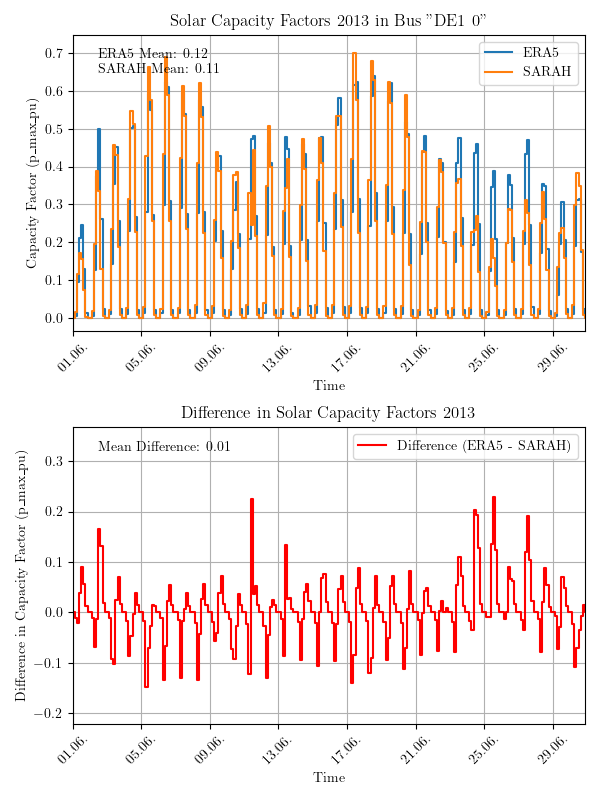

(                 Network 1                                      \
 Generator DE1 0 solar-2025 DE1 0  solar-2000 DE1 0  solar-2005   
 count          2920.000000       2920.000000       2920.000000   
 mean              0.115585          0.115585          0.115585   
 std               0.166499          0.166499          0.166499   
 min               0.000000          0.000000          0.000000   
 25%               0.000000          0.000000          0.000000   
 50%               0.010372          0.010372          0.010372   
 75%               0.201166          0.201166          0.201166   
 max               0.679991          0.679991          0.679991   
 
                                                                  \
 Generator DE1 0  solar-2010 DE1 0  solar-2015 DE1 0  solar-2020   
 count           2920.000000       2920.000000       2920.000000   
 mean               0.115585          0.115585          0.115585   
 std                0.166499          0.166499          

In [99]:
#n = xr.open_dataset("../input/profile_solar_2013.nc")
n1 = pypsa.Network("../input/elec2013_s_37_lv1.0__3H-B-solar+p3_2025.nc")
n2 = pypsa.Network('../input/v6_elec_s_37_lv1.0__3H-B-solar+p3_2025.nc')

compare_solar_capacity_factors(n1, n2, 'DE1 0', [6]) #specify month in brackets

# Scen 1: Plot weather year comparison

## scen 1: old weather year comparision

/tmp/ipykernel_716047/74380540.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



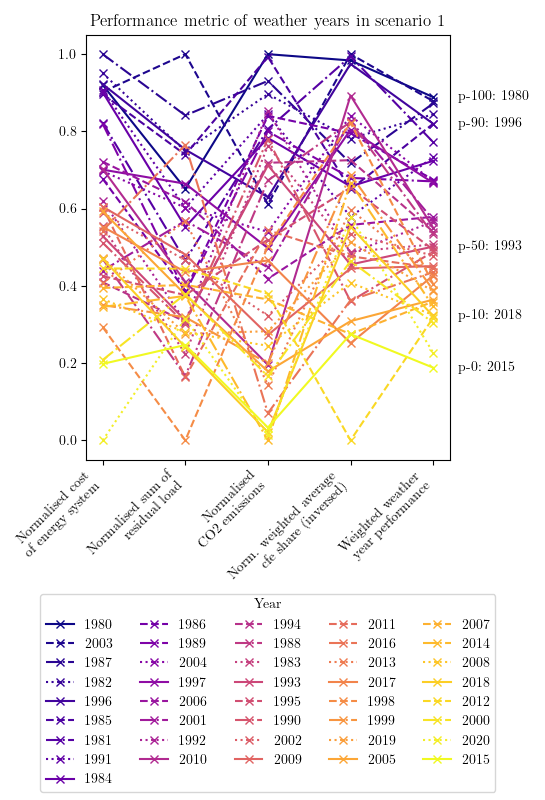

In [96]:
def plot_wy(df):
    df.reset_index(inplace=True)
    # Split the dataframe based on the unique policies in column 0
    groups = df.groupby(df.columns[0])

    # Prepare the colormap
    total_years = len(df['year'].unique())
    colormap = cm.get_cmap('plasma', total_years)  # Get the 'plasma' colormap
    normalize = mcolors.Normalize(vmin=0, vmax=total_years-1)

    line_styles = ['-', '--', '-.', ':']
    markers = ['x'] #, 's', '^', 'D', '*', 'p', 'h']

    fig, ax = plt.subplots(groups.ngroups,1,figsize=(5.45, 8*groups.ngroups), sharex=True)
    if not isinstance(ax, np.ndarray):
        ax = [ax]

    # Iterate over each group
    for j, (group_name, group_df) in enumerate(groups):
        rename_dict = {
            "emissions" : "Total CO2 emissions",
            "objective" : "Total cost of energy system",
            "rldc_sum" : "Total residual load",
            "system_grid_cfe_wavg" : "Average grid carbon\nbound energy share",
            "emissions_weight" : "Normalised\nCO2 emissions",
            "objective_weight" : "Normalised cost\nof energy system",
            "rldc_sum_weight" : "Normalised sum of\nresidual load",
            "system_grid_cfe_wavg_weight" : "Norm. weighted average\ncfe share (inversed)",
            "weighted_score_weight" : "Weighted weather\nyear performance"
        }
        group_df.rename(columns=rename_dict, inplace=True)
        # pick columns to plot
        columns_to_plot = [  "Normalised cost\nof energy system","Normalised sum of\nresidual load","Normalised\nCO2 emissions", "Norm. weighted average\ncfe share (inversed)", "Weighted weather\nyear performance"] # column for column in group_df.columns if 'Normalised' in column or 'Weighted' in column]

        # Plot the line plots for each year
        for i, (index, row) in enumerate(group_df.iterrows()):
            # Extract the year and the values for the criteria columns
            year = row['year']
            # Calculate the color
            color = colormap(normalize(i))
            linestyle = line_styles[i % len(line_styles)]
            marker = markers[i % len(markers)]
            # Plot the criteria performances for this year
            ax[j].plot(columns_to_plot, row[columns_to_plot], linestyle=linestyle, marker=marker, label=str(year), color=color)

        # Calculate specific percentiles
        percentiles = [100, 90, 50, 10, 0]
        percentile_values = np.percentile(group_df[rename_dict.get('weighted_score_weight')], percentiles)
        # Highlight and annotate the percentiles
        for percentile, value in zip(percentiles, percentile_values):
            closest_year = group_df.iloc[(group_df[rename_dict.get('weighted_score_weight')]-value).abs().argsort()[:1]]['year'].values[0]
            #ax[j].axhline(y=value, linestyle='--', color='gray', alpha=0.7)
            ax[j].text(len(columns_to_plot)-0.7 , value, f'p-{percentile}: {closest_year}', verticalalignment='center')
            
        # Add legend and labels
        ax[j].legend(loc='upper center', bbox_to_anchor=(0.5 ,-0.3), title='Year', ncol=5)
        ax[j].set_title(f'Performance metric of weather years in scenario 1')

        
        # Improve the layout
        plt.xticks(rotation=45, ha="right")  # Rotate the x-axis labels for better readability
        plt.tight_layout(rect=[0,-0.08,1,1])  # Adjust the layout to make room for the legend and x-axis labels
        plt.savefig(f"../plots/weather_year_performance_scenario1.pgf", format='pgf')
        plt.show

df = pd.read_csv('../results/04_20-EU_DE_scenario_1/csvs/10/2025/DE/p1/summary_pick.csv', index_col=0)
plot_wy(df)

In [121]:
df = pd.read_csv('../results/04_04-EU_DE_scenario_1/csvs/10/2025/DE/p1/summary_pick.csv', index_col=0)
df.describe()

year     emissions     objective      rldc_sum  \
count    41.000000  4.100000e+01  4.100000e+01  4.100000e+01   
mean   2000.000000  2.631478e+08  1.065945e+11  2.058362e+09   
std      11.979149  9.149868e+06  2.865406e+09  2.429424e+07   
min    1980.000000  2.476716e+08  9.965747e+10  2.009461e+09   
25%    1990.000000  2.563162e+08  1.047413e+11  2.041318e+09   
50%    2000.000000  2.632362e+08  1.062475e+11  2.055904e+09   
75%    2010.000000  2.708944e+08  1.081452e+11  2.073242e+09   
max    2020.000000  2.773930e+08  1.119053e+11  2.118242e+09   

       system_grid_cfe_wavg  emissions_weight  objective_weight  \
count             41.000000         41.000000         41.000000   
mean               0.656571          0.520709          0.566390   
std                0.006941          0.307854          0.233952   
min                0.640780          0.000000          0.000000   
25%                0.651285          0.290855          0.415079   
50%                0.657454          0.523684          0.538061   
75%                0.661722          0.781350          0.693000   
max                0.672175          1.000000          1.000000   

       rldc_sum_weight  system_grid_cfe_wavg_weight  weighted_score_weight  
count        41.000000                    41.000000              41.000000  
mean          0.449541                     0.497033               0.508418  
std           0.223331                     0.221077               0.149988  
min           0.000000                     0.000000               0.247188  
25%           0.292854                     0.332951               0.395444  
50%           0.426946                     0.468905               0.494903  
75%           0.586331                     0.665389               0.632269  
max           1.000000                     1.000000               0.809115

## scen 1: Compare weather years

/tmp/ipykernel_716047/1521978846.py:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



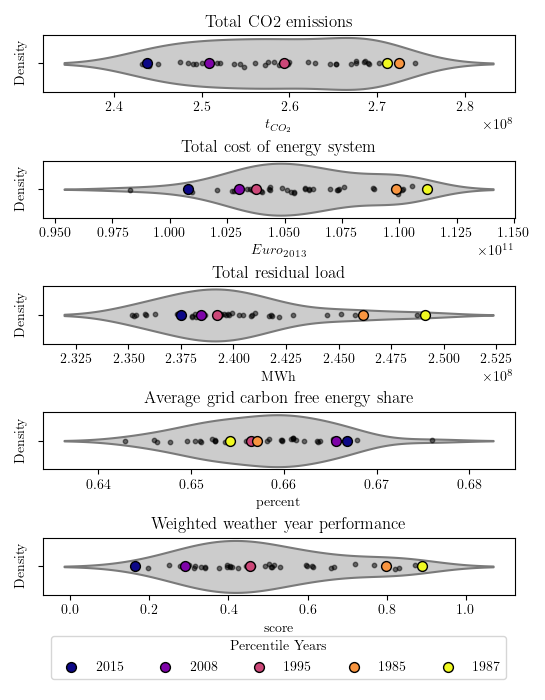

year     emissions     objective      rldc_sum  \
count    41.000000  4.100000e+01  4.100000e+01  4.100000e+01   
mean   2000.000000  2.586992e+08  1.058037e+11  2.400307e+08   
std      11.979149  9.314511e+06  3.037114e+09  3.414129e+06   
min    1980.000000  2.431547e+08  9.828004e+10  2.351912e+08   
25%    1990.000000  2.508032e+08  1.037595e+11  2.380068e+08   
50%    2000.000000  2.588660e+08  1.054144e+11  2.395747e+08   
75%    2010.000000  2.675521e+08  1.075863e+11  2.416826e+08   
max    2020.000000  2.743862e+08  1.111921e+11  2.491051e+08   

       system_grid_cfe_wavg  emissions_weight  objective_weight  \
count             41.000000         41.000000         41.000000   
mean               0.657871          0.497719          0.582688   
std                0.006952          0.298241          0.235215   
min                0.642952          0.000000          0.000000   
25%                0.652611          0.244898          0.424365   
50%                0.658223          0.503058          0.552534   
75%                0.662183          0.781179          0.720739   
max                0.675943          1.000000          1.000000   

       rldc_sum_weight  system_grid_cfe_wavg_weight  weighted_score_weight  
count        41.000000                    41.000000              41.000000  
mean          0.347817                     0.547788               0.494003  
std           0.245377                     0.210726               0.189392  
min           0.000000                     0.000000               0.164788  
25%           0.202360                     0.417067               0.340696  
50%           0.315043                     0.537114               0.455601  
75%           0.466543                     0.707232               0.612477  
max           1.000000                     1.000000               0.888919

In [100]:
# Load data from CSV
df = pd.read_csv('../results/04_21-EU_DE_scenario_1/csvs/10/2025/DE/p1/summary_pick.csv')

# Columns to plot, now including 'weighted_score_weight'
columns_to_plot = ['emissions', 'objective', 'rldc_sum', 'system_grid_cfe_wavg', 'weighted_score_weight']

# Rename dict for plot titles
rename_dict = {
    "emissions" : "Total CO2 emissions",
    "objective" : "Total cost of energy system",
    "rldc_sum" : "Total residual load",
    "system_grid_cfe_wavg" : "Average grid carbon free energy share",
    "weighted_score_weight" : "Weighted weather year performance"
}

# Rename dict for x-axis labels
renamevalue_dict = {
    "emissions" : "$t_{CO_2}$",
    "objective" : "$Euro_{2013}$",
    "rldc_sum" : "MWh",
    "system_grid_cfe_wavg" : "percent",
    "weighted_score_weight" : "score"
}

# Calculate percentiles for 'weighted_score_weight' and find corresponding years
percentiles = [0, 0.1, 0.5, 0.9, 1.0]
percentile_values = df['weighted_score_weight'].quantile(percentiles)
percentile_years = [df.iloc[(df['weighted_score_weight'] - value).abs().argsort()[:1]]['year'].values[0] for value in percentile_values]

# Colormap for plotting
colormap = cm.get_cmap('plasma', len(percentile_years))
colors = [colormap(i) for i in range(len(percentile_years))]

# Set up the matplotlib figure
plt.figure(figsize=(5.45, 7))

# Create violin plots and overlay percentile data
for i, column in enumerate(columns_to_plot):
    plt.subplot(len(columns_to_plot), 1, i + 1)
    sns.violinplot(data=df, x=column, inner=None, color="0.8")  # inner=None removes quartile lines
    plt.scatter(x=df[column], y=np.random.normal(0, 0.02, size=len(df)), color='black', alpha=0.5, s=10)

    # Overlay percentiles
    for year, color in zip(percentile_years, colors):
        year_data = df[df['year'] == year][column]
        plt.scatter(year_data, [0]*len(year_data), color=color, s=50, edgecolor='k', label=f'{year}')

    # Apply renaming for titles and x-axis labels
    plt.title(rename_dict[column])
    plt.xlabel(renamevalue_dict[column])
    plt.ylabel('Density')

# Improve layout and add legend outside the plot
plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the layout
plt.subplots_adjust(bottom=0.15)  # Adjust subplot parameters to give some space for the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels/handles
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.5, -0.6), loc='upper center', title="Percentile Years", ncols=5)

# Save the figure as a pgf file
plt.savefig('../plots/weather_year_performance_scenario1.pgf', format='pgf')

# Show the plot
plt.show()

df.describe()


# scen 1: deep dive rldc


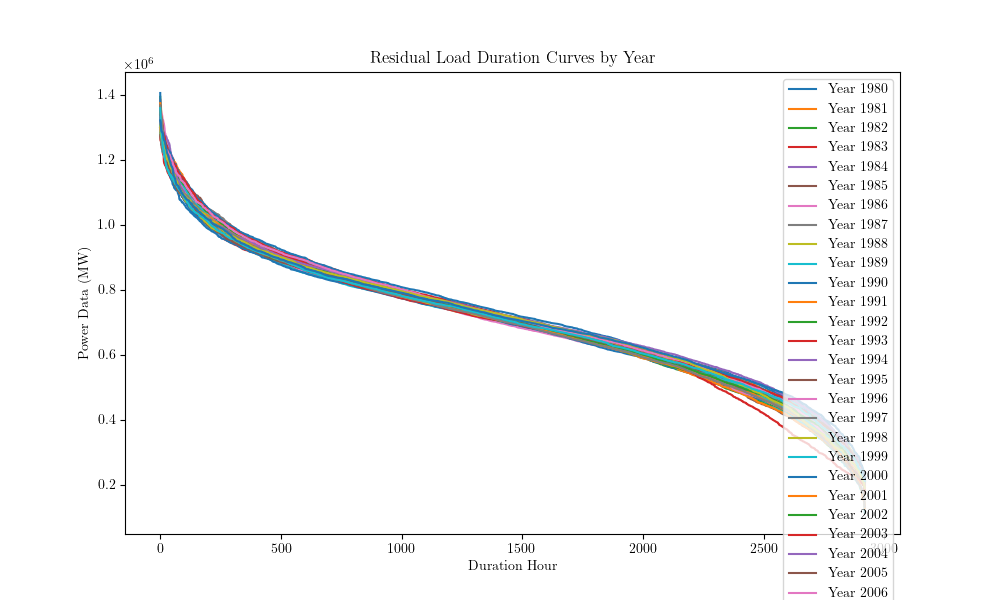

In [102]:
def plot_rldc_fromsummary(csvfile):
    # Load the CSV file into a DataFrame
    data = pd.read_csv(csvfile)
    
    # Sort data first by 'year' and then by 'variable' in descending order for proper curve plotting
    data.sort_values(by=['year', 'variable'], ascending=[True, False], inplace=True)
    
    # Get unique years from the 'year' column
    years = data['year'].unique()
    
    # Set up the plot
    plt.figure(figsize=(10, 6))
    
    # Plot each year's residual load duration curve
    for year in years:
        # Filter data for the specific year
        yearly_data = data[data['year'] == year]
        
        # Plotting the curve
        plt.plot(yearly_data['variable'], yearly_data['total'], label=f'Year {year}')
    
    # Adding plot title and labels
    plt.title('Residual Load Duration Curves by Year')
    plt.xlabel('Duration Hour')
    plt.ylabel('Power Data (MW)')
    plt.legend()
    
    # Show the plot
    plt.show()


plot_rldc_fromsummary('../results/04_21-EU_DE_scenario_1/csvs/10/2025/DE/p1/summary_rldc.csv')

/home/tillotillson/miniforge3/envs/247-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/tmp/ipykernel_716047/1138187981.py:34: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



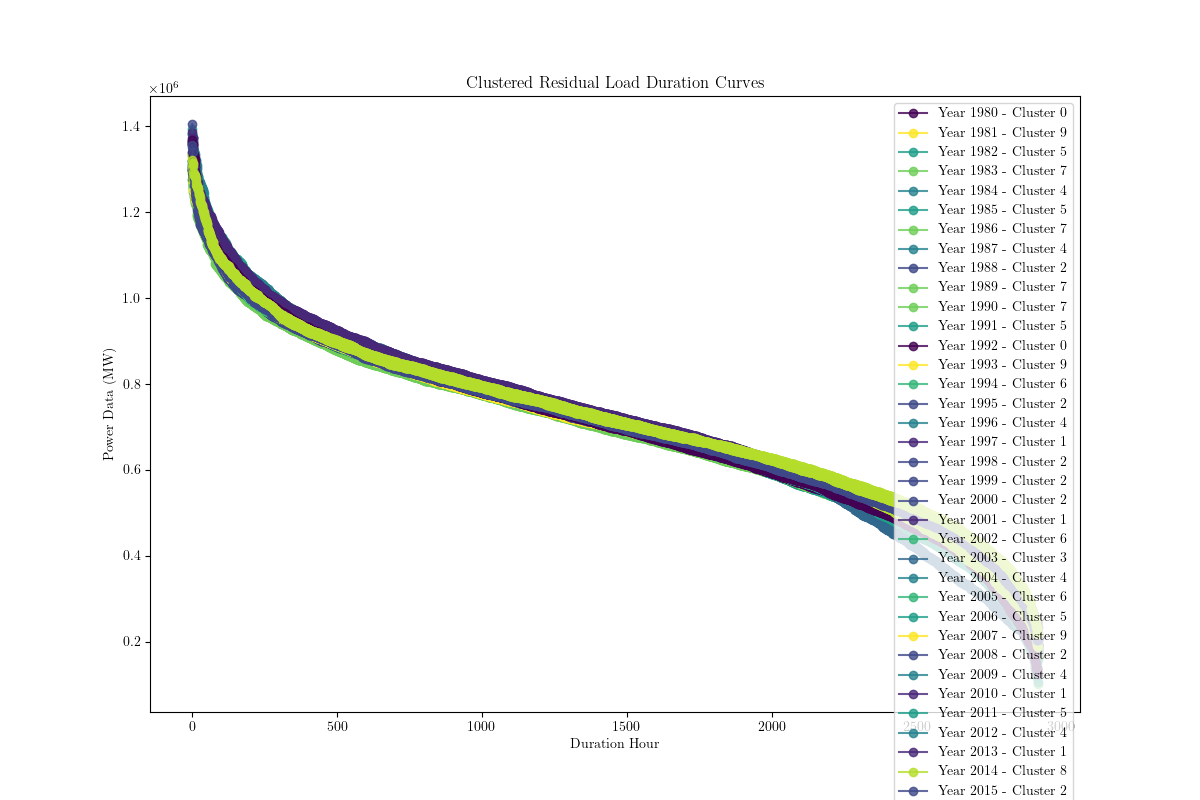

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def cluster_and_plot_load_duration(csv_file, n_clusters=3):
     # Load the CSV file into a DataFrame
    data = pd.read_csv(csv_file)
    
    # Sort data by 'year' and then by 'variable' in descending order
    data.sort_values(by=['year', 'variable'], ascending=[True, False], inplace=True)
    
    # Prepare data for clustering
    years = data['year'].unique()
    features = []
    
    for year in years:
        yearly_data = data[data['year'] == year]
        # Ensure all vectors have the same length if 'variable' steps differ between years
        # Interpolation could be used here if necessary
        features.append(yearly_data['total'].tolist())
    
    # Standardize features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    # Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(features)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    color_palette = plt.cm.get_cmap('viridis', n_clusters)  # Get a color map for n_clusters
    
    for idx, year in enumerate(years):
        cluster = clusters[idx]
        yearly_data = data[data['year'] == year]
        plt.plot(yearly_data['variable'], yearly_data['total'], marker='o', alpha=0.8, color=color_palette(cluster),
                 label=f'Year {year} - Cluster {cluster}')

    # Create a legend for clusters
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Removing duplicates in legend
    plt.legend(by_label.values(), by_label.keys())
    
    plt.title('Clustered Residual Load Duration Curves')
    plt.xlabel('Duration Hour')
    plt.ylabel('Power Data (MW)')
    plt.show()
# Example usage
cluster_and_plot_load_duration('../results/04_21-EU_DE_scenario_1/csvs/10/2025/DE/p1/summary_rldc.csv', n_clusters=10)


# scen 1: installed capacities in 5 wy


/tmp/ipykernel_716047/4206767943.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



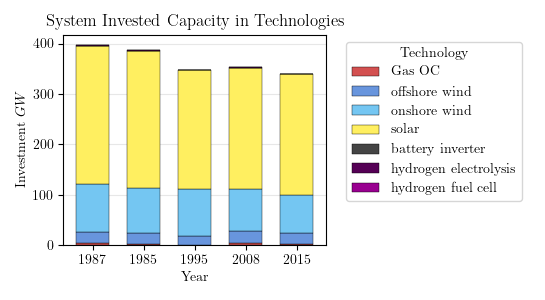

technology  Gas OC  offshore wind  onshore wind     solar  battery inverter  \
year                                                                          
1985        1420.0        23404.0       87915.0  273439.0               0.0   
1987        3770.0        22061.0       95203.0  274784.0               0.0   
1995         857.0        17899.0       91862.0  236239.0               0.0   
2008        4985.0        22381.0       84632.0  239735.0               0.0   
2015        1435.0        21780.0       77220.0  238875.0               0.0   

technology  hydrogen electrolysis  hydrogen fuel cell  
year                                                   
1985                       1008.0               419.0  
1987                       1192.0               439.0  
1995                       1008.0               371.0  
2008                       1219.0               437.0  
2015                        686.0               243.0

In [105]:
df = pd.read_csv('../results/04_21-EU_DE_scenario_1/csvs/10/2025/DE/p1/summary_weather_years.csv')
selected_years = [1987, 1985, 1995, 2008, 2015]
df_filtered = df[df['year'].isin(selected_years) & df['variable'].str.contains('system_inv_')]

# Applying the rename mapping to the 'variable' column
df_filtered.loc[:,'technology'] = df_filtered['variable'].replace(rename_system_simple, regex=True)

# Grouping the data by year and technology for the investment sum
investment_data = df_filtered.groupby(['year', 'technology'])['ref'].sum().unstack(fill_value=0)


# Reorder the columns according to the preferred order while ensuring all desired technologies are listed
investment_data = investment_data[[tech for tech in preferred_order if tech in investment_data.columns]]
# Reorder the rows according to the selected years
investment_data_sorted = investment_data.loc[selected_years]


# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(5.45, 3))
(investment_data_sorted/1e3).plot(kind='bar', stacked=True, color=[tech_colors.get(x) for x in investment_data_sorted.columns], ax=ax, width=0.65, edgecolor = "black", linewidth=0.3, zorder=10)
ax.set_title('System Invested Capacity in Technologies')
ax.set_ylabel('Investment $GW$')
ax.set_xlabel('Year')
plt.xticks(rotation=0)
ax.grid(alpha=0.3, axis='y')
ax.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.savefig('../plots/system_investment_selected_years.pgf', format='pgf')
plt.show()

investment_data.round(0)

# scen 2: plot cost, generation and capacity and cfe share

## scen 2: cost and revenue

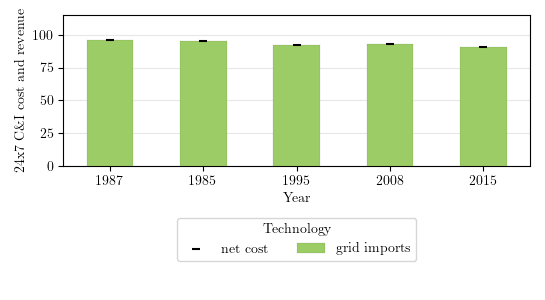

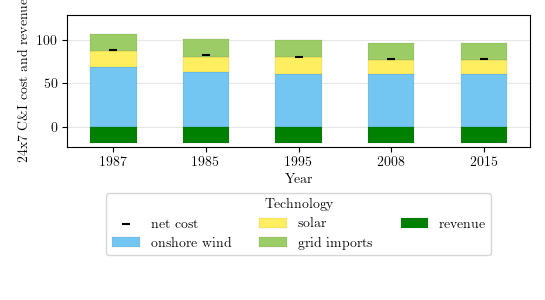

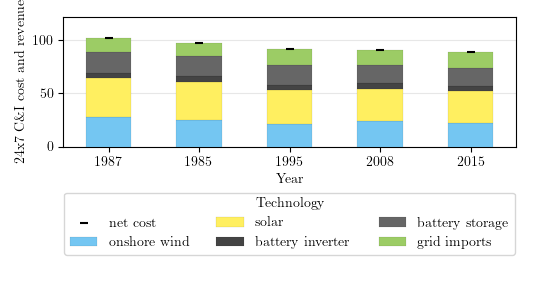

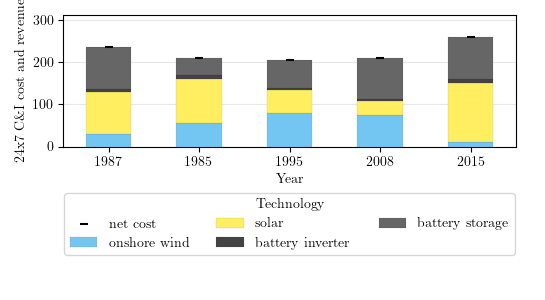

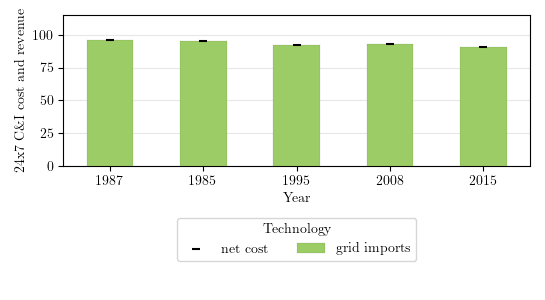

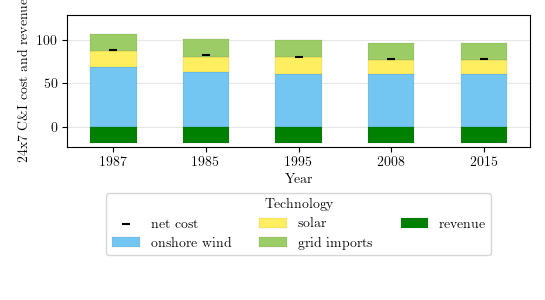

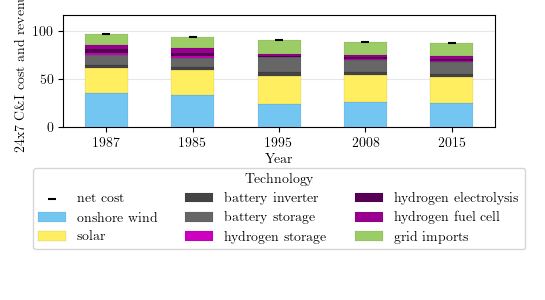

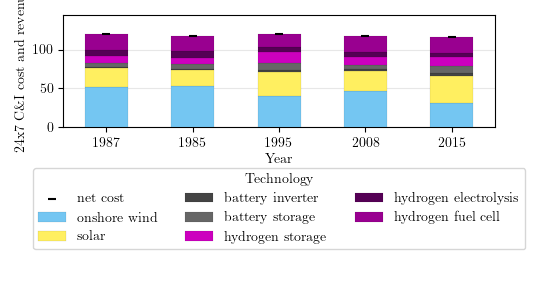

In [23]:
def ci_costnrev(df, scenario ,selected_years):
        # Filter DataFrame for selected years and necessary variables
    df = df[df['year'].isin(selected_years)]

    # Filter for cost-related rows and the total demand
    cost_rows = df[df['variable'].str.startswith('ci_cost')].copy()
    demand_data = df[df['variable'] == 'ci_demand_total'].copy()
    revenue_data = df[df['variable'] == 'ci_average_revenue'].copy()
    revenue_data[scenario] = -revenue_data[scenario]

    # Normalize costs by total demand for each year
    for year in cost_rows['year'].unique():
        total_demand = demand_data[demand_data['year'] == year][scenario].values[0]
        cost_rows.loc[cost_rows['year'] == year, scenario] /= total_demand

    #clean up data
    cost_rows['variable'] = cost_rows['variable'].str.replace('ci_cost_', '').map(rename_ci_cost)  # Clean up variable names
    revenue_data['variable'] = 'revenue'
    cost_rows = pd.concat([cost_rows, revenue_data])

    # Pivot the table for easier plotting
    plot_data = cost_rows.pivot(index='year', columns='variable', values=scenario)

    # Reorder the columns according to the preferred order. technologies not listed in the preferred order will be appended at the end
    ordered_cols = [col for col in preferred_order if col in plot_data.columns]
    extra_cols = [col for col in plot_data.columns if col not in preferred_order]
    plot_data = plot_data[ordered_cols + extra_cols]
    # Reorder the rows according to the selected years
    plot_data = plot_data.loc[selected_years]

    #drop empty columns
    to_drop = plot_data.columns[(plot_data.abs() < 0.1).all(axis=0)]
    plot_data.drop(to_drop, axis=1, inplace=True)

    fig, ax = plt.subplots()
    fig.set_size_inches((5.45, 3))

    # Plotting
    plot_data.plot(kind="bar", stacked=True, ax=ax, color=tech_colors, edgecolor="black", linewidth=0.05, zorder=3)

    #set marker for net cost
    netc=plot_data.sum(axis=1)
    ax.scatter(range(len(netc)), netc.values, color='black', marker='_', label='net cost', zorder=11)

    #Layout
    ax.set_ylabel("24x7 C\&I cost and revenue")
    ax.set_ylim(plot_data[plot_data < 0].sum(axis=1).min()*1.2, plot_data[plot_data > 0].sum(axis=1).max()*1.2)
    ax.set_xlabel('Year')
    plt.xticks(rotation=0)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(title='Technology', bbox_to_anchor=(0.5, -0.3), loc='upper center', ncols=3)
    plt.tight_layout()
    plt.savefig(f'../plots/scen_2_ci_cost_revenue_{pal}_{scenario}.pgf', format='pgf')
    plt.show()

selected_years = [1987, 1985, 1995, 2008, 2015]
palette = ['p1', 'p2']
policy = ['ref', 'res100', 'cfe95', 'cfe100']
for pal in palette:
    df = pd.read_csv(f'../results/04_21-EU_DE_scenario_2/csvs/10/2025/DE/{pal}/summary_weather_years.csv')
    for pol in policy:
        ci_costnrev(df, pol, selected_years)

df = pd.read_csv('../results/04_21-EU_DE_scenario_2/csvs/10/2025/DE/p2/summary_weather_years.csv',) 
# Example of how to call this function with your DataFrame `df` and the list of selected years
#ci_costnrev(df, 'cfe100', [1987, 1985, 1995, 2008, 2015])


## scen 2: generation

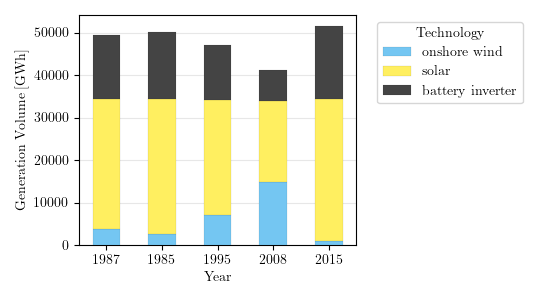

In [133]:

def plot_generation_volume(df, scenario, selected_years):
    # Filter DataFrame for selected years
    df = df[df['year'].isin(selected_years)]

    # Filter for generation-related rows
    generation_rows = df[df['variable'].str.startswith('ci_generation_')].copy()

    # Normalize generation volumes by dividing by 1000 (e.g., converting MWh to GWh)
    generation_rows[scenario] = generation_rows[scenario] / 1000.0

    # Rename variables using the provided dictionary
    generation_rows['variable'] = generation_rows['variable'].str.replace('ci_generation_', '').replace(rename_ci_capacity)

    # Pivot the table for easier plotting
    plot_data = generation_rows.pivot(index='year', columns='variable', values=scenario)

    # Reorder the columns based on keys in the renaming dictionary if required
    ordered_cols = [col for col in preferred_order if col in plot_data.columns]
    extra_cols = [col for col in plot_data.columns if col not in ordered_cols]
    plot_data = plot_data[ordered_cols + extra_cols]
    # Reorder the rows according to the selected years
    plot_data = plot_data.loc[selected_years]

    #drop empty columns
    to_drop = plot_data.columns[(plot_data.abs() < 0.1).all(axis=0)]
    plot_data.drop(to_drop, axis=1, inplace=True)

    # Plotting
    fig, ax = plt.subplots()
    fig.set_size_inches((5.45, 3))

    plot_data.plot(kind="bar", stacked=True, ax=ax, color=tech_colors, edgecolor="black", linewidth=0.05, zorder=10)
    ax.set_ylabel("Generation Volume [GWh]")
    ax.set_xlabel('Year')
    plt.xticks(rotation=0)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


selected_years = [1987, 1985, 1995, 2008, 2015]
df = pd.read_csv('../results/04_21-EU_DE_scenario_2/csvs/10/2025/DE/p1/summary_weather_years.csv') 
plot_generation_volume(df, 'cfe100', selected_years)

## scen 2: capacity

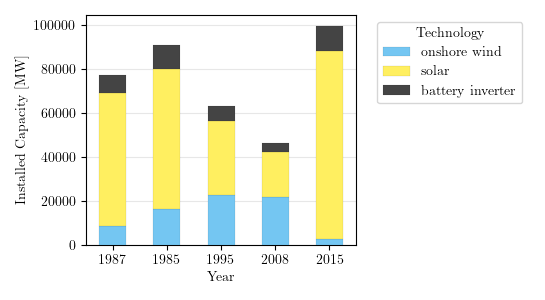

In [138]:
def plot_capacity_over_years(df, scenario, selected_years):
    # Filter DataFrame for selected years
    df = df[df['year'].isin(selected_years)]

    # Filter for capacity-related rows
    capacity_rows = df[df['variable'].str.startswith('ci_cap_')].copy()

    # Apply renaming to match the provided dictionary
    capacity_rows['variable'] = capacity_rows['variable'].str.replace('ci_cap_', '').replace(rename_ci_capacity)
    #drop battery_charger from capacity_rows
    capacity_rows = capacity_rows[~capacity_rows['variable'].str.contains('battery_charger')]

    # Pivot the table for easier plotting
    plot_data = capacity_rows.pivot(index='year', columns='variable', values=scenario)

    # Reorder the columns based on keys in the renaming dictionary if required
    ordered_cols = [col for col in preferred_order if col in plot_data.columns]
    extra_cols = [col for col in plot_data.columns if col not in ordered_cols]
    plot_data = plot_data[ordered_cols + extra_cols]
    # Reorder the rows according to the selected years
    plot_data = plot_data.loc[selected_years]

    # Plotting
    fig, ax = plt.subplots()
    fig.set_size_inches((5.45, 3))
    plot_data.plot(kind="bar", stacked=True, ax=ax, color=tech_colors, edgecolor="black", linewidth=0.05, zorder=10)
    ax.set_ylabel("Installed Capacity [MW]")
    ax.set_xlabel('Year')
    plt.xticks(rotation=0)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example usage
df = pd.read_csv('../results/04_21-EU_DE_scenario_2/csvs/10/2025/DE/p1/summary_weather_years.csv')  # Correct the path as necessary
selected_years = [1987, 1985, 1995, 2008, 2015]
plot_capacity_over_years(df, 'cfe100', selected_years)

## scen2: cfe share

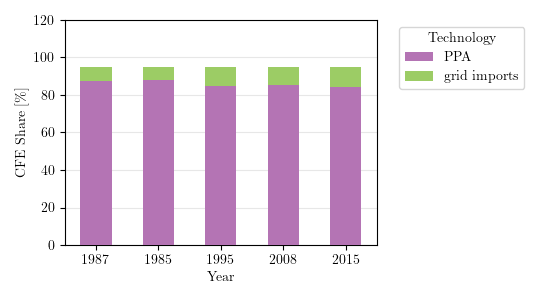

In [140]:
def plot_cfe_share(df, scenario, selected_years):
    # Filter DataFrame for selected years
    df = df[df['year'].isin(selected_years)]

    # Define types to plot and construct variable names
    types = ["local", "grid"]
    variable_names = [f"ci_fraction_clean_used_{t}" for t in types]

    # Filter for CFE share-related rows
    cfe_share_rows = df[df['variable'].isin(variable_names)].copy()

    # Rename using a dictionary comprehension and further mappings
    cfe_share_rows['variable'] = cfe_share_rows['variable'].map(
        {f"ci_fraction_clean_used_{t}": t for t in types}
    ).replace({"local": "PPA", "grid": "grid imports"})

    # Pivot the table for easier plotting
    plot_data = cfe_share_rows.pivot(index='year', columns='variable', values=scenario)

    # Convert to percentages and round
    plot_data = (100 * plot_data).round(1)

    # Reorder the columns based on keys in the renaming dictionary if required
    ordered_cols = [col for col in preferred_order if col in plot_data.columns]
    extra_cols = [col for col in plot_data.columns if col not in ordered_cols]
    plot_data = plot_data[ordered_cols + extra_cols]
    # Reorder the rows according to the selected years
    plot_data = plot_data.loc[selected_years]

    # Plotting
    fig, ax = plt.subplots()
    fig.set_size_inches((5.45, 3))
    plot_data.plot(kind="bar", stacked=True, ax=ax, color=tech_colors , zorder=10)
    ax.set_ylabel("CFE Share [$\%$]")
    ax.set_xlabel('Year')
    ax.set_ylim(0, 120)
    plt.xticks(rotation=0)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

df = pd.read_csv('../results/04_21-EU_DE_scenario_2/csvs/10/2025/DE/p1/summary_weather_years.csv')  # Correct the path as necessary
selected_years = [1987, 1985, 1995, 2008, 2015]
plot_cfe_share(df, 'cfe95', selected_years)

# scen 3: investigate negative prices

INFO:pypsa.io:Imported network ref.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


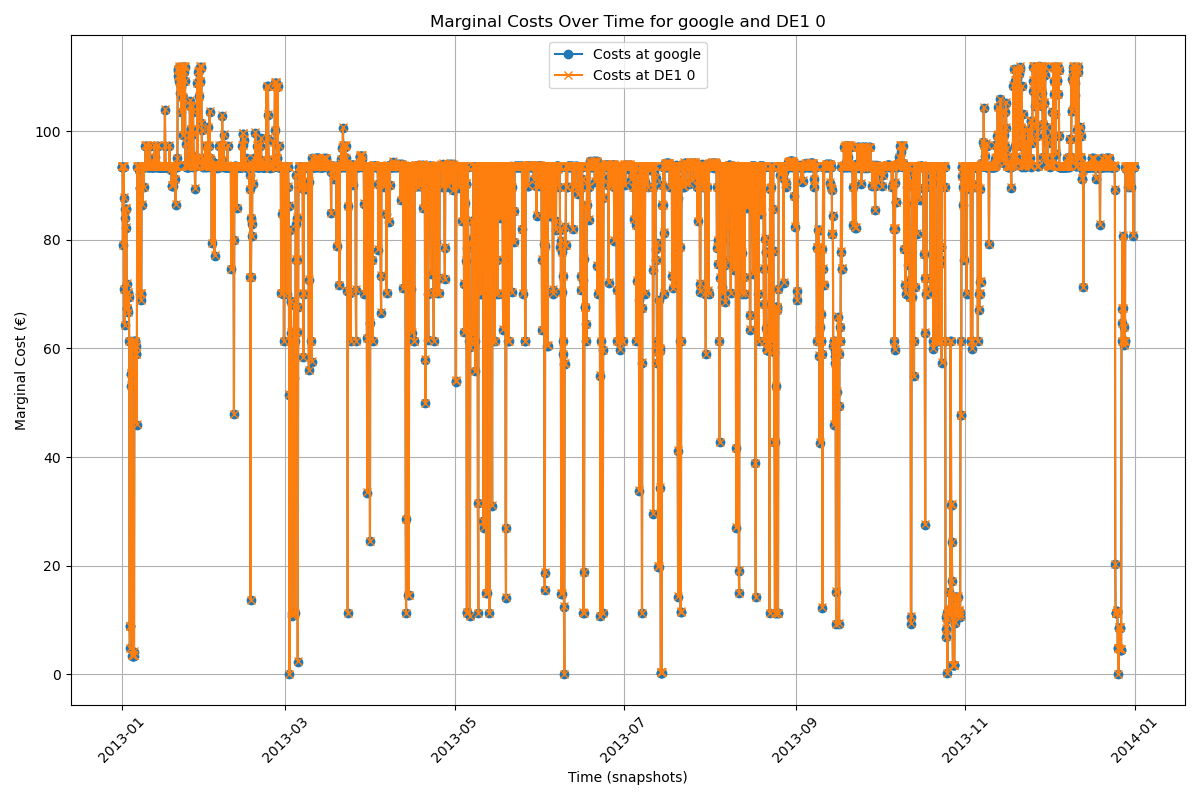

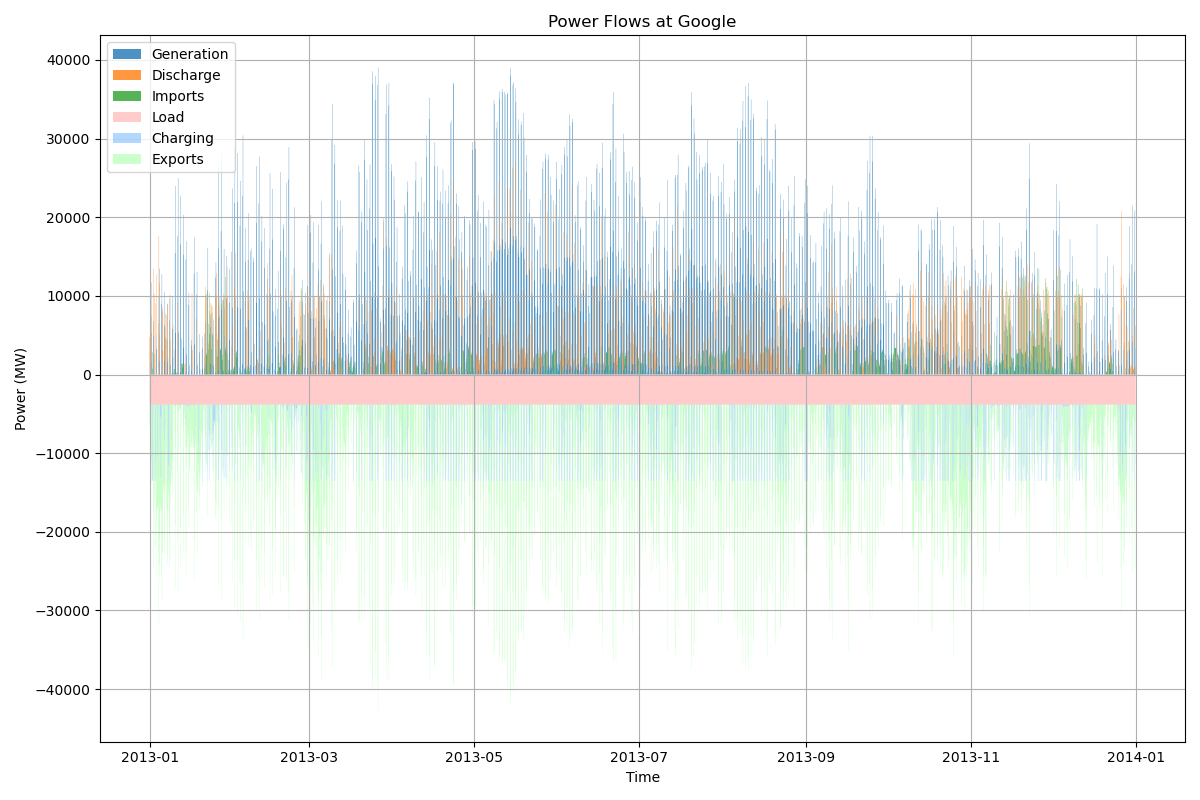

In [44]:
def plot_dual_prices_of_two_nodes(network, node1_name, node2_name):
    """
    Plots the dual variable (marginal prices) of two specified nodes as costs over time from a solved PyPSA network.
    
    Parameters:
    - network: A solved PyPSA Network object.
    - node1_name: A string, the name of the first node in the network whose costs are to be plotted.
    - node2_name: A string, the name of the second node in the network whose costs are to be plotted.
    """
    
    # Check for node existence and extract marginal prices
    if node1_name not in network.buses_t.marginal_price:
        raise ValueError(f"The specified node name '{node1_name}' does not exist in the network's marginal prices.")
    if node2_name not in network.buses_t.marginal_price:
        raise ValueError(f"The specified node name '{node2_name}' does not exist in the network's marginal prices.")
    
    marginal_prices_node1 = network.buses_t.marginal_price[node1_name]
    marginal_prices_node2 = network.buses_t.marginal_price[node2_name]
    
    # Create a DataFrame for plotting
    df = pd.DataFrame({
        'Time': marginal_prices_node1.index,
        f'Costs at {node1_name}': marginal_prices_node1.values,
        f'Costs at {node2_name}': marginal_prices_node2.values
    })
    
    # Plotting the data
    plt.figure(figsize=(12, 8))
    plt.plot(df['Time'], df[f'Costs at {node1_name}'], marker='o', linestyle='-', label=f'Costs at {node1_name}')
    plt.plot(df['Time'], df[f'Costs at {node2_name}'], marker='x', linestyle='-', label=f'Costs at {node2_name}')
    plt.title(f'Marginal Costs Over Time for {node1_name} and {node2_name}')
    plt.xlabel('Time (snapshots)')
    plt.ylabel('Marginal Cost (€)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_power(network):
    gen_name = ['google solar', 'google wind']
    discharge_link = 'google battery discharger'
    import_link = 'google import'
    node_name = 'google load'
    charge_link = 'google battery charger'
    export_link = 'google export'

     # Prepare data for the second subplot
    time = network.snapshots
    pos_data = {
        'Generation': network.generators_t.p.loc[:, network.generators_t.p.columns.intersection(gen_name)].sum(axis=1),
        'Discharge': network.links_t.p0[discharge_link] if discharge_link in network.links_t.p0 else 0,
        'Imports': network.links_t.p0[import_link] if import_link in network.links_t.p0 else 0
    }

    neg_data = {
        'Load': -network.loads_t.p_set[node_name] if node_name in network.loads_t.p_set else 0,
        'Charging': -network.links_t.p0[charge_link] if charge_link in network.links_t.p0 else 0,
        'Exports': -network.links_t.p0[export_link] if export_link in network.links_t.p0 else 0
    }

    plt.figure(figsize=(12, 8))
    # Plotting positive contributions
    plt.stackplot(time, pos_data.values(), step='post', labels=pos_data.keys(), alpha=0.8)
    # Plotting negative contributions
    plt.stackplot(time, neg_data.values(), step='post', labels=neg_data.keys(), alpha=0.5, colors=['#ff9999', '#66b3ff', '#99ff99'])

    plt.title('Power Flows at Google')
    plt.ylabel('Power (MW)')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Set x-label for the bottom plot
    plt.xlabel('Time')

    # Show plot
    plt.tight_layout()
    plt.show()

n = pypsa.Network("../results/04_13-EU_DE_scenario3/networks/10/2025/DE/p1/1998/ref.nc")
plot_dual_prices_of_two_nodes(n, 'google', 'DE1 0')
plot_power(n)

INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


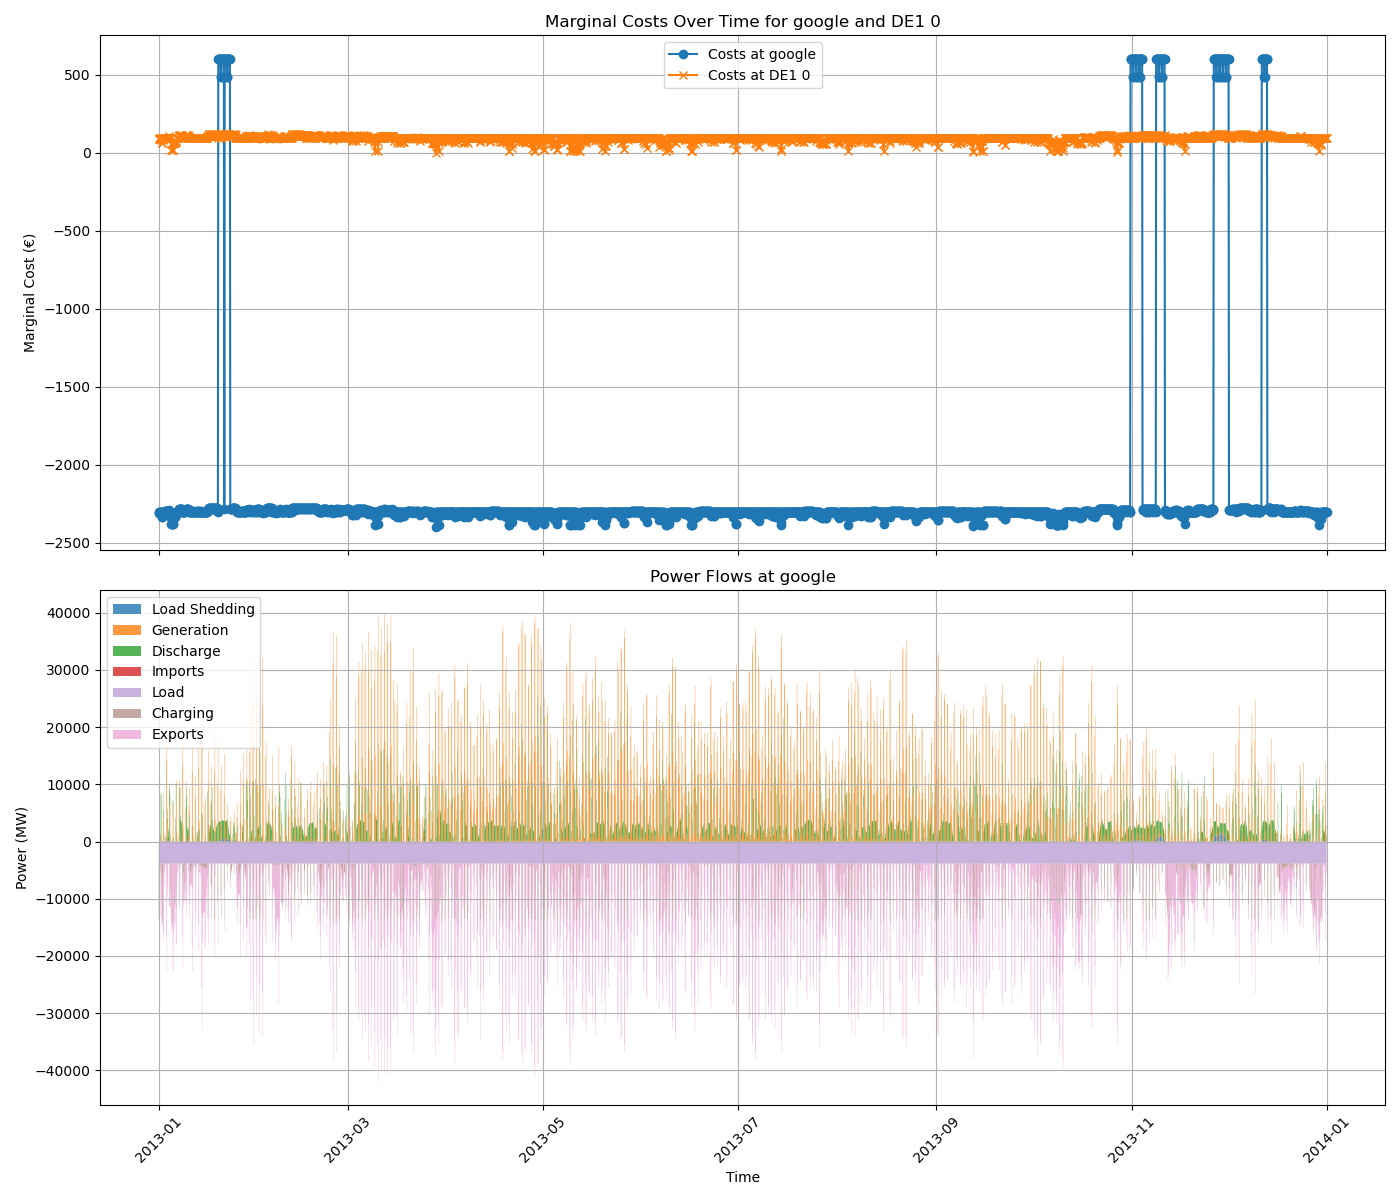

In [64]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_network_data(network, node1_name, node2_name):
    """
    Plots the dual variable (marginal prices) of two specified nodes as costs over time 
    and the power flows of the first node in a stacked area chart, both plots sharing the x-axis.
    
    Parameters:
    - network: A solved PyPSA Network object.
    - node1_name: A string, the name of the first node in the network whose costs and power flows are to be plotted.
    - node2_name: A string, the name of the second node in the network whose costs are to be plotted.
    """
    
    # Ensure the node names exist in the network's data
    if node1_name not in network.buses_t.marginal_price:
        raise ValueError(f"The specified node name '{node1_name}' does not exist in the network's marginal prices.")
    if node2_name not in network.buses_t.marginal_price:
        raise ValueError(f"The specified node name '{node2_name}' does not exist in the network's marginal prices.")
    
    # Extract marginal prices
    marginal_prices_node1 = network.buses_t.marginal_price[node1_name]
    marginal_prices_node2 = network.buses_t.marginal_price[node2_name]
    
    # Prepare power flow data for the first node
    gen_name = ['google solar', 'google wind']
    
    discharge_link = 'google battery discharger'
    import_link = 'google import'
    charge_link = 'google battery charger'
    export_link = 'google export'
    
    # Extract and prepare power data, assuming naming conventions are correct and columns exist
    pos_data = {
        'Load Shedding' : network.generators_t.p.loc[:, f"{node1_name} load shedding"],
        'Generation': network.generators_t.p.loc[:, network.generators_t.p.columns.intersection(gen_name)].sum(axis=1),
        'Discharge': network.links_t.p0[discharge_link] if discharge_link in network.links_t.p0 else 0,
        'Imports': network.links_t.p0[import_link] if import_link in network.links_t.p0 else 0
    }
    neg_data = {
        'Load': -network.loads_t.p_set[f"{node1_name} load"] if f"{node1_name} load" in network.loads_t.p_set else 0,
        'Charging': -network.links_t.p0[charge_link] if charge_link in network.links_t.p0 else 0,
        'Exports': -network.links_t.p0[export_link] if export_link in network.links_t.p0 else 0
    }

    # Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

    # Plotting marginal prices
    axs[0].plot(marginal_prices_node1.index, marginal_prices_node1.values, label=f'Costs at {node1_name}', marker='o')
    axs[0].plot(marginal_prices_node2.index, marginal_prices_node2.values, label=f'Costs at {node2_name}', marker='x')
    axs[0].set_title(f'Marginal Costs Over Time for {node1_name} and {node2_name}')
    axs[0].set_ylabel('Marginal Cost (€)')
    axs[0].legend()
    axs[0].grid(True)

    # Plotting power flows
    time = network.snapshots
    axs[1].stackplot(time, pos_data.values(), labels=pos_data.keys(), alpha=0.8, step='post')
    axs[1].stackplot(time, neg_data.values(), labels=neg_data.keys(), alpha=0.5, step='post')
    axs[1].set_title('Power Flows at ' + node1_name)
    axs[1].set_ylabel('Power (MW)')
    axs[1].legend(loc='upper left')
    axs[1].grid(True)

    # Set common x-axis properties
    plt.xlabel('Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage, assuming `network` is your loaded and solved PyPSA network object
n = pypsa.Network("../results/04_14-EU_DE_scenario3/networks/10/2025/DE/p1/1987/cfe100.nc")
plot_network_data(n, 'google', 'DE1 0')


# Network capacities generators links comparison

In [8]:
def plot_capacity_summaries(*networks):
    """
    Plots the summaries of capacity (p_nom) per carrier for each bus in given networks,
    and adds a subplot showing the difference in p_nom values between networks.
    Each dataframe is plotted in a subplot with consistent color coding for carriers.

    Parameters:
    *networks (variable number of pandas.DataFrame): networks to be plotted.
    """
    # Number of networks
    num_dfs = len(networks)

    # Creating subplots, with one extra for the difference plot
    fig, axes = plt.subplots(num_dfs + 1, 1, figsize=(10, 5 * (num_dfs + 1)))

    # Ensuring axes is a list even if there's only one subplot
    if num_dfs == 1:
        axes = [axes]

    # Initialize a DataFrame to store the summed values for difference calculation
    summed_values = []

    # Generate a consistent set of colors for carriers
    all_carriers = set()
    for network in networks:
        all_carriers.update(network.generators['carrier'].unique())
    colors = mcolors.XKCD_COLORS
    carrier_colors = {carrier: color for carrier, color in zip(all_carriers, colors)}
    carrier_colors.update({
        "offwind": "#6895dd",
        "offwind-ac": "#6895dd",
        "offwind-dc": "#6895dd",
        "onwind": "#74c6f2",
        "solar": "#ffef60",
        })

    for i, network in enumerate(networks):
        # Check if network has been solved and a valid p_nom_opt column exists
        if 'p_nom_opt' in network.generators.columns and not network.generators['p_nom_opt'].isna().any():
            capacity_column = 'p_nom_opt'
        else:
            capacity_column = 'p_nom'
            
        # Filtering only the relevant columns: 'bus', 'carrier', and 'p_nom'
        filtered_df = network.generators[['bus', 'carrier', capacity_column]]
        filtered_df.rename(columns={capacity_column: 'p_nom'}, inplace=True) if capacity_column != 'p_nom' else None

        # Group and sum the p_nom values per bus and carrier
        grouped_df = filtered_df.groupby(['bus', 'carrier']).sum().unstack().fillna(0)
        summed_values.append(grouped_df)

        # Plotting on the respective subplot with consistent colors
        (grouped_df/1000).plot(kind='bar', stacked=True, ax=axes[i], color=[carrier_colors[carrier] for carrier in grouped_df.columns.get_level_values(1)])
        axes[i].set_title(f'Sum of {capacity_column} per Carrier for each Bus (Network {i+1})')
        axes[i].set_xlabel('Bus')
        axes[i].set_ylabel(f'Sum of {capacity_column} [GW]')
        axes[i].grid(True, axis='y')
        
        #custom legend
        carrier_labels = [carrier for carrier in grouped_df.columns.get_level_values(1)]
        custom_legend = [plt.Line2D([0], [0], color=carrier_colors[carrier], lw=4) for carrier in carrier_labels]
        axes[i].legend(custom_legend, carrier_labels, title="Carriers", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Calculating and plotting the difference
    if num_dfs > 1:
        # Assuming only 2 networks for difference calculation
        difference_df = summed_values[1].subtract(summed_values[0], fill_value=0)
        (difference_df/1000).plot(kind='bar', stacked=True, ax=axes[-1], color=[carrier_colors[carrier] for carrier in difference_df.columns.get_level_values(1)])
        axes[-1].set_title('Difference in p_nom per Carrier for each Bus (Network 2 - Network 1)')
        axes[-1].set_xlabel('Bus')
        axes[-1].set_ylabel('Difference in Sum of p_nom [GW]')
        axes[-1].legend(custom_legend, carrier_labels, title="Carriers", bbox_to_anchor=(1.05, 1), loc='upper left')

        # Annotation for total difference
        total_difference_per_carrier = difference_df.sum(axis=0)
        annotation_text = "\n".join([f"{carrier}: {total_diff / 1000:.2f} GW" for carrier, total_diff in total_difference_per_carrier.iteritems()])
        axes[-1].text(0.5, 0.5, annotation_text, transform=axes[-1].transAxes, ha='center', fontsize=10)
        axes[-1].grid(True, axis='y')

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [9]:
def plot_link_capacity_summaries(*networks):
    """
    Plots the summaries of capacity (p_nom) per carrier for each link in given networks,
    filtering buses with carriers 'AC' or 'battery'.
    Each dataframe is plotted in a subplot with consistent color coding for link carriers.

    Parameters:
    *networks (variable number of pandas.DataFrame): networks to be plotted.
    """
    # Number of networks
    num_dfs = len(networks)

    # Creating subplots, with one extra for the difference plot
    fig, axes = plt.subplots(num_dfs + 1, 1, figsize=(10, 5 * (num_dfs + 1)))

    # Ensuring axes is a list even if there's only one subplot
    if num_dfs == 1:
        axes = [axes]
    
    # Initialize a DataFrame to store the summed values for difference calculation
    summed_values = []
    
    # Generate a consistent set of colors for carriers
    all_carriers = set()
    for network in networks:
        all_carriers.update(network.links['carrier'].unique())
    colors = mcolors.CSS4_COLORS
    carrier_colors = {carrier: color for carrier, color in zip(all_carriers, colors)}

    for i, network in enumerate(networks):
        # Filter for buses with 'AC' or 'battery' carriers
        ac_battery_buses = network.buses[network.buses.carrier.isin(['AC'])].index #'battery'

        # Filtering links with relevant buses and columns: 'bus1', 'carrier', and 'p_nom'
        filtered_links = network.links[network.links.bus1.isin(ac_battery_buses)]
        filtered_links = filtered_links[['bus1', 'carrier', 'p_nom']]

        # Group and sum the p_nom values per bus1 and carrier
        grouped_links = filtered_links.groupby(['bus1', 'carrier']).sum().unstack().fillna(0)
        summed_values.append(grouped_links)

        # Plotting on the respective subplot with consistent colors
        (grouped_links/1000).plot(kind='bar', stacked=True, ax=axes[i], color=[carrier_colors[carrier] for carrier in grouped_links.columns.get_level_values(1)])
        axes[i].set_title(f'Sum of p_nom per Carrier for each Link (Network {i+1})')
        axes[i].set_xlabel('Bus')
        axes[i].set_ylabel('Sum of p_nom [GW]')
        axes[i].grid(True, axis='y')
        axes[i].legend(title='Carrier')

            # Calculating and plotting the difference
    if num_dfs > 1:
        # Assuming only 2 networks for difference calculation
        difference_df = summed_values[1].subtract(summed_values[0], fill_value=0)
        (difference_df/1000).plot(kind='bar', stacked=True, ax=axes[-1], color=[carrier_colors[carrier] for carrier in difference_df.columns.get_level_values(1)])
        axes[-1].set_title('Difference in p_nom per Carrier for each Bus (DataFrame 2 - DataFrame 1)')
        axes[-1].set_xlabel('Bus')
        axes[-1].set_ylabel('Difference in Sum of p_nom [GW]')

        # Annotation for total difference
        total_difference_per_carrier = difference_df.sum(axis=0)
        annotation_text = "\n".join([f"{carrier}: {total_diff / 1000:.2f} GW" for carrier, total_diff in total_difference_per_carrier.iteritems()])
        axes[-1].text(0.5, 0.5, annotation_text, transform=axes[-1].transAxes, ha='center', fontsize=10)
        axes[-1].grid(True, axis='y')
        
    # Adjust layout
    plt.tight_layout()
    plt.show()

In [10]:
# compare generator dataframe

def compare_generator_df(net1, net2):
    """
    Compare the generators dataframes of two PyPSA networks.
    
    :param net1: First PyPSA network object
    :param net2: Second PyPSA network object
    :return: DataFrame showing differences
    """
    # Extract generators dataframes
    gen1 = net1.generators
    gen2 = net2.generators

    # Align columns in both dataframes
    gen1, gen2 = gen1.align(gen2, axis=1)

    # Compare and find differences
    diff = pd.concat([gen1, gen2]).drop_duplicates(keep=False)

    return diff

## Comparison of input networks capacities (unsolved)

with comparing capacities I found a double attachment of vres capacities in pypsa-eur code.

INFO:pypsa.io:Imported network v6_elec_s_37_lv1.0__3H-B-solar+p3_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Index(['AL1 0 residential rural biomass boiler-2025',
       'AT1 0 residential rural biomass boiler-2025',
       'BA1 0 residential rural biomass boiler-2025',
       'BE1 0 residential rural biomass boiler-2025',
       'BG1 0 residential rural biomass boiler-2025',
       'CH1 0 residential rural biomass boiler-2025',
       'CZ1 0 residential rural biomass boiler-2025',
       'DE1 0 residential rural biomass boiler-2025',
       'DK1 0 residential rural biomass boiler-2025',
       'DK2 0 residential rural biomass boiler-2025',
       ...
       'MK1 0 services urban decentral biomass boiler-2025',
       'NL1 0 services urban decentral biomass boiler-2025',
       'NO2 0 services urban decentral biomass boiler-2025',
       'PL1 0 services urban decentral biomass boiler-2025',
       'PT1 0 services urban decentr

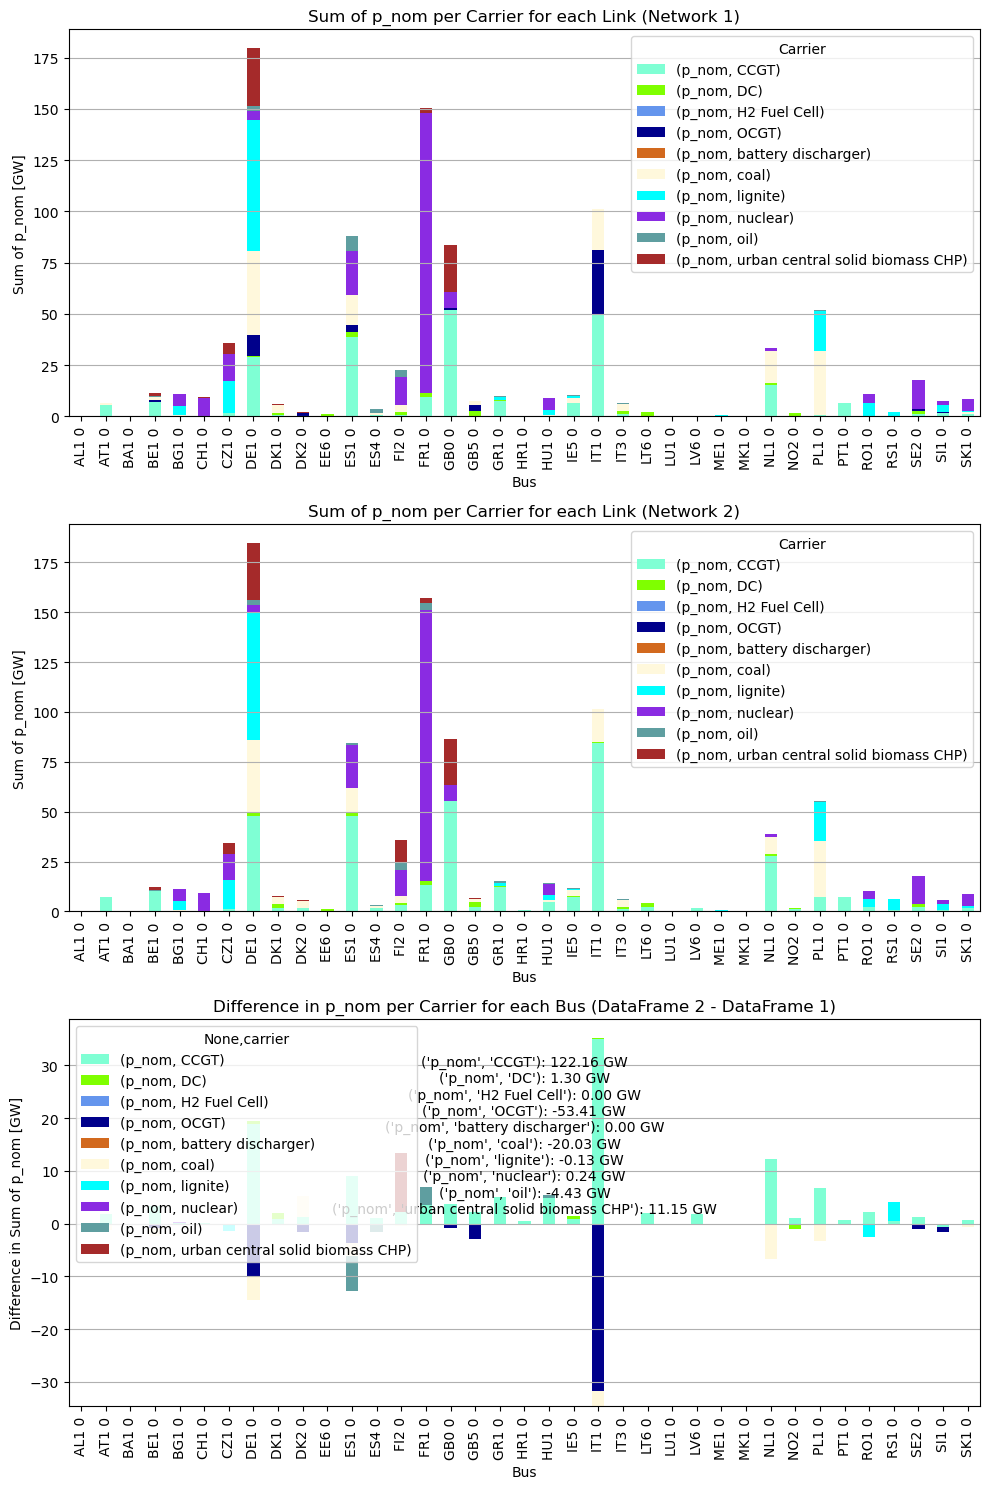

/tmp/ipykernel_6592/3454978569.py:76: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



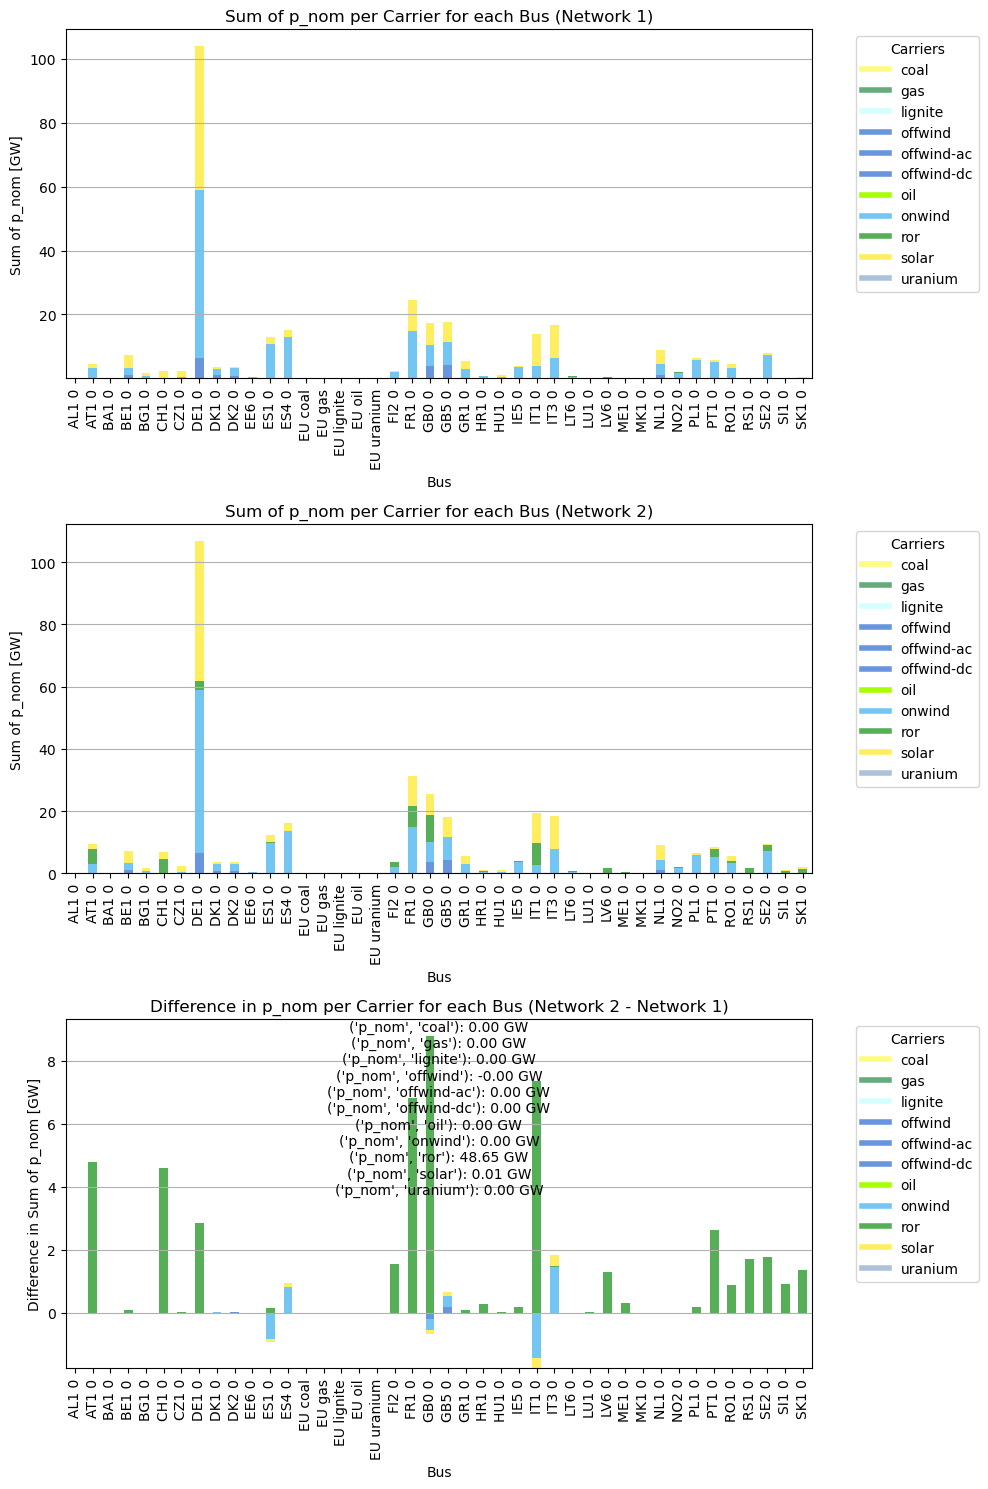

In [11]:
n1 = pypsa.Network('../input/v6_elec_s_37_lv1.0__3H-B-solar+p3_2025.nc')
n2 = pypsa.Network('../input/elec2013_s_37_lv1.0__3H-B-solar+p3_2025_double_vre.nc')
plot_link_capacity_summaries(n1,n2)
plot_capacity_summaries(n1,n2)

tryna find the capacity differences in solved networks.

Index(['AL1 0 residential rural biomass boiler-2025',
       'AT1 0 residential rural biomass boiler-2025',
       'BA1 0 residential rural biomass boiler-2025',
       'BE1 0 residential rural biomass boiler-2025',
       'BG1 0 residential rural biomass boiler-2025',
       'CH1 0 residential rural biomass boiler-2025',
       'CZ1 0 residential rural biomass boiler-2025',
       'DE1 0 residential rural biomass boiler-2025',
       'DK1 0 residential rural biomass boiler-2025',
       'DK2 0 residential rural biomass boiler-2025',
       ...
       'MK1 0 services urban decentral biomass boiler-2025',
       'NL1 0 services urban decentral biomass boiler-2025',
       'NO2 0 services urban decentral biomass boiler-2025',
       'PL1 0 services urban decentral biomass boiler-2025',
       'PT1 0 services urban decentral biomass boiler-2025',
       'RO1 0 services urban decentral biomass boiler-2025',
       'RS1 0 services urban decentral biomass boiler-2025',
       'SE2 0 services

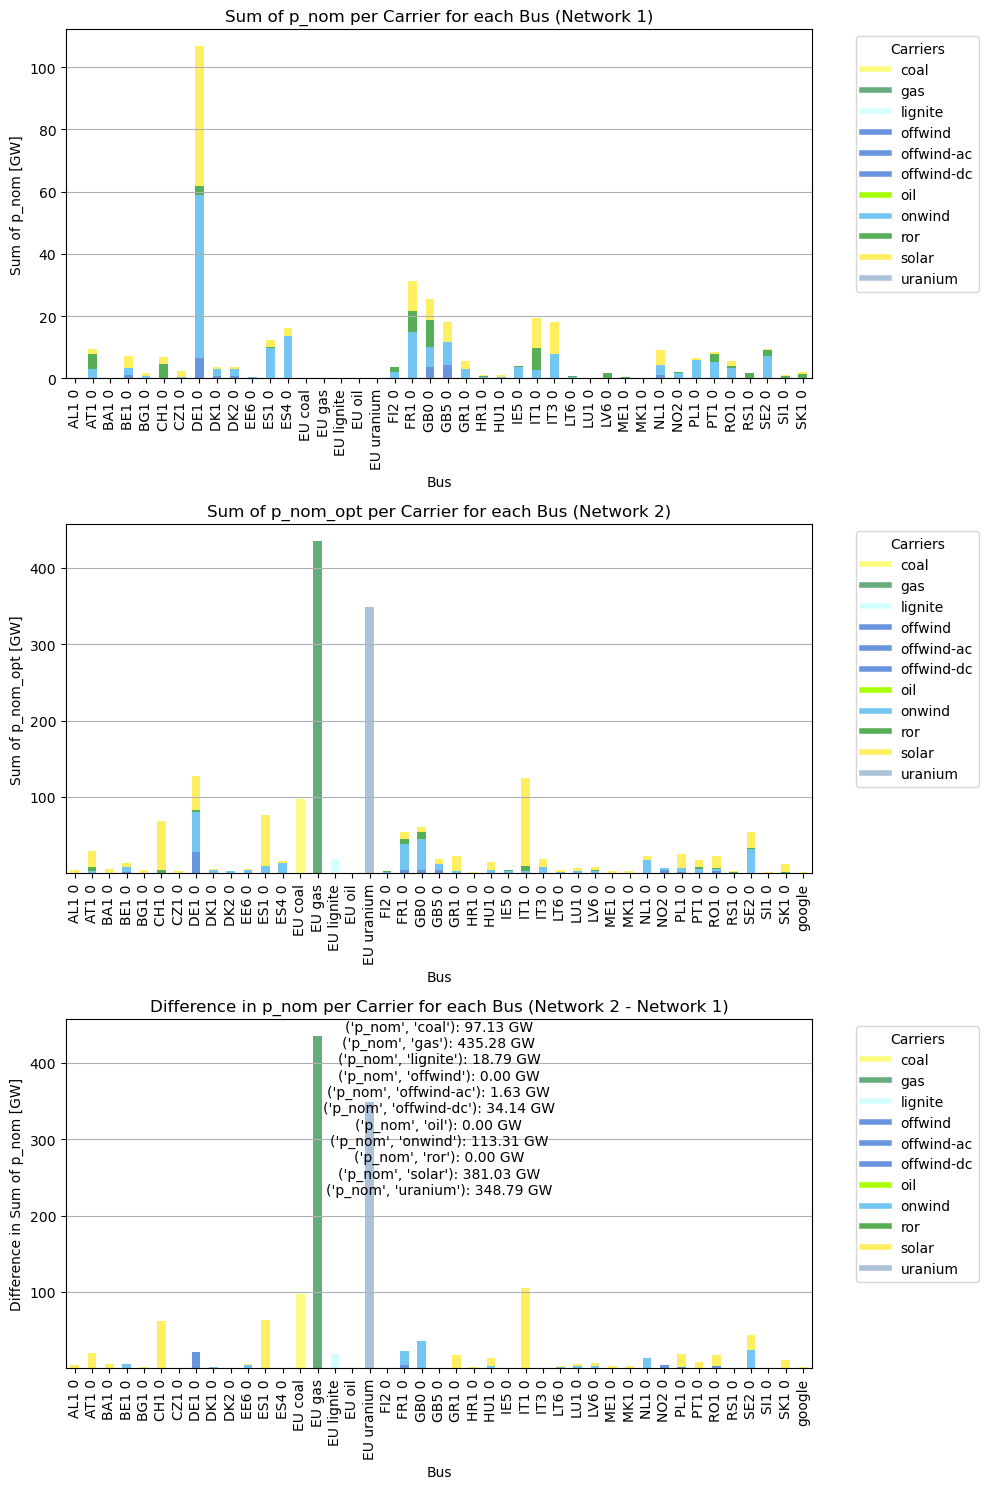

In [12]:
n1 = pypsa.Network('../input/elec2013_s_37_lv1.0__3H-B-solar+p3_2025_fix_vre_SARAH.nc')# results/12_13_validationEU_fix_vre_SARAH/networks/10/2025/IE/p1/2013/res100.nc')# 
n2 = pypsa.Network('../results/12_07_validationEU_fix_vre_SARAH/networks/10/2025/IE/p1/2013/res100.nc')
plot_capacity_summaries(n1,n2)

Index(['AL1 0 residential rural biomass boiler-2025',
       'AT1 0 residential rural biomass boiler-2025',
       'BA1 0 residential rural biomass boiler-2025',
       'BE1 0 residential rural biomass boiler-2025',
       'BG1 0 residential rural biomass boiler-2025',
       'CH1 0 residential rural biomass boiler-2025',
       'CZ1 0 residential rural biomass boiler-2025',
       'DE1 0 residential rural biomass boiler-2025',
       'DK1 0 residential rural biomass boiler-2025',
       'DK2 0 residential rural biomass boiler-2025',
       ...
       'MK1 0 services urban decentral biomass boiler-2025',
       'NL1 0 services urban decentral biomass boiler-2025',
       'NO2 0 services urban decentral biomass boiler-2025',
       'PL1 0 services urban decentral biomass boiler-2025',
       'PT1 0 services urban decentral biomass boiler-2025',
       'RO1 0 services urban decentral biomass boiler-2025',
       'RS1 0 services urban decentral biomass boiler-2025',
       'SE2 0 services

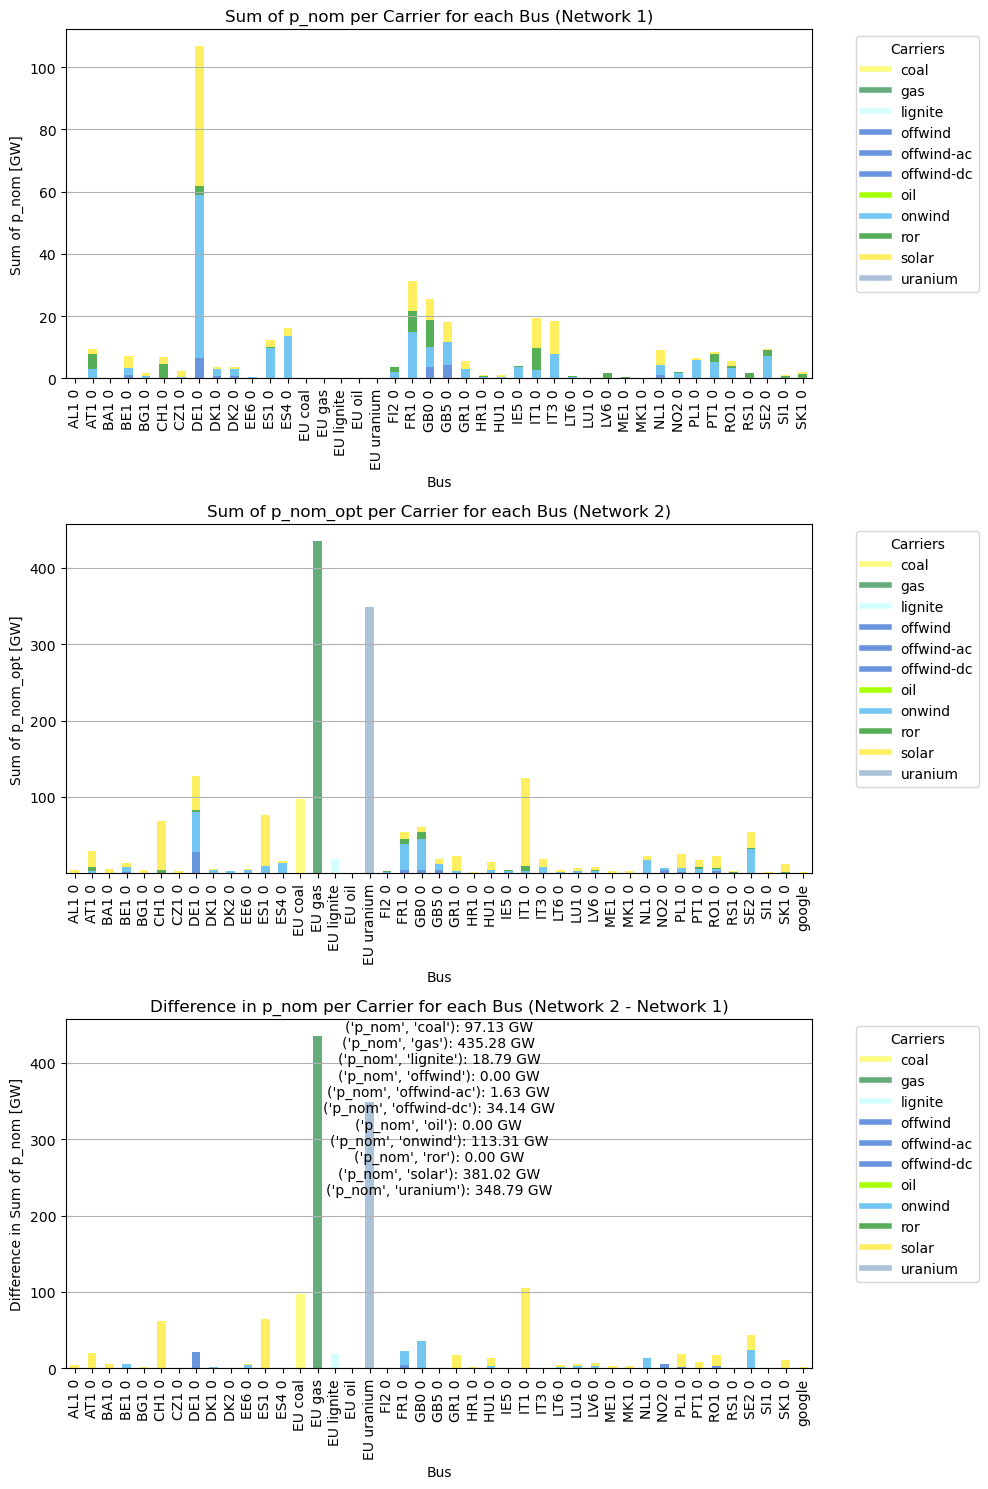

In [13]:
n1 = pypsa.Network('../input/elec2013_s_37_lv1.0__3H-B-solar+p3_2025.nc')#'../../pypsa-eur/results/weatheryeartest/prenetworks/elec2013_s_37_lv1.0__3H-B-solar+p3_2025.nc') #'../results/validationEU/networks/10/2025/IE/p1/2013/res100.nc') 
n2 = pypsa.Network('../results/12_07_validationEU_fix_vre_SARAH/networks/10/2025/IE/p1/2013/res100.nc') #'../input/v6_elec_s_37_lv1.0__3H-B-solar+p3_2025.nc') #'../input/elec2013_s_37_lv1.0__3H-B-solar+p3_2025.nc') #
plot_capacity_summaries(n1,n2)

# Comparison of p_nom_max and p_nom_opt


In [31]:
def plot_bar_charts_adjacent(n):
    # Define the color scheme
    tech_colors = {
        "offwind": "#6895dd",  # offshore wind
        "onwind": "#74c6f2",   # onshore wind
        "ror": "#298c81",      # run of river
        "solar": "#ffef60"     # solar
    }

    # Adjust carrier names for offwind variants
    n.generators['carrier'] = n.generators['carrier'].replace(['offwind-dc', 'offwind-ac'], 'offwind')

    # Filter only relevant columns
    relevant_carriers = ['offwind', 'onwind', 'ror', 'solar']
    filtered_gens = n.generators[n.generators['carrier'].isin(relevant_carriers)]

    # Data for extendable and non-extendable generators
    extendable_gens = filtered_gens[filtered_gens.p_nom_extendable]
    extended_gens = extendable_gens[extendable_gens.p_nom_opt > 0]
    non_extendable_gens = filtered_gens[~filtered_gens.p_nom_extendable]

    # Group and sum data
    sum_extendable = extendable_gens.groupby(['bus', 'carrier']).p_nom_max.sum().unstack(fill_value=0).div(1000)
    sum_extended = extended_gens.groupby(['bus', 'carrier']).p_nom_opt.sum().unstack(fill_value=0).div(1000)
    sum_non_extendable = non_extendable_gens.groupby(['bus', 'carrier']).p_nom_opt.sum().unstack(fill_value=0).div(1000)

    # Ensure both dataframes have the same index and columns
    common_index = sum_extendable.index.union(sum_non_extendable.index)
    common_columns = relevant_carriers
    sum_extendable = sum_extendable.reindex(index=common_index, columns=common_columns, fill_value=0)
    sum_extended = sum_extended.reindex(index=common_index, columns=common_columns, fill_value=0)
    sum_non_extendable = sum_non_extendable.reindex(index=common_index, columns=common_columns, fill_value=0)

    # Plotting
    fig, ax = plt.subplots(3,1,figsize=(15, 15))

    # Width of a bar
    bar_width = 0.2

    # Positions of the extendable and non-extendable bars
    index = np.arange(len(common_index))
    extendable_pos = index + bar_width
    extended_pos = index
    non_extendable_pos = index - bar_width

    """# Stacked bar chart for extendable generators
    bottom = np.zeros(len(common_index))
    for col in sum_extendable.columns:
        ax[0].bar(extendable_pos, sum_extendable[col], bar_width, bottom=bottom, color=tech_colors.get(col, '#333333'), label='Ext: ' + col if np.all(bottom == 0) else "")
        bottom += sum_extendable[col].values"""
        
    #stacked bar chart for extended generators
    bottom = np.zeros(len(common_index))
    for col in sum_extended.columns:
        ax[0].bar(extended_pos, sum_extended[col], bar_width, bottom=bottom, color=tech_colors.get(col, '#333333'), label='Ext: ' + col if np.all(bottom == 0) else "")
        bottom += sum_extended[col].values

    # Stacked bar chart for non-extendable generators
    bottom = np.zeros(len(common_index))
    for col in sum_non_extendable.columns:
        ax[0].bar(non_extendable_pos, sum_non_extendable[col], bar_width, bottom=bottom, color=tech_colors.get(col, '#333333'), label='Non-Ext: ' + col if np.all(bottom == 0) else "")
        bottom += sum_non_extendable[col].values

    ax[0].set_xlabel('Bus')
    ax[0].set_ylabel('Generator Capacity [GW]')
    ax[0].set_title('Extendable and Non-Extendable Generator Capacities by Bus and Carrier')
    ax[0].set_xticks(index)
    ax[0].set_xticklabels(common_index, rotation=90)
    ax[0].legend()
    
    # Plot 2: Bar Chart for Quotients
    quotient = sum_non_extendable.div(sum_extendable.where(sum_extendable != 0, 0.000001))  # Avoid division by zero
    quotient.pop('ror')  # Remove run of river generators
    quotient.plot(kind='bar', ax=ax[1], color=[tech_colors.get(x, '#333333') for x in quotient.columns])
    ax[1].set_title('Quotient of already build capacity (<2020) and maximum potential per Carrier')
    ax[1].set_ylabel('Quotient')
    
    # Plot 3: Bar Chart for Quotients
    quotient = sum_extended.div(sum_non_extendable.where(sum_non_extendable != 0, 0.000001))  # Avoid division by zero
    quotient.pop('ror')  # Remove run of river generators
    quotient.plot(kind='bar', ax=ax[2], color=[tech_colors.get(x, '#333333') for x in quotient.columns])
    ax[2].set_title('Quotient of extended capacity (>2020) and already build capacity (<2020) per Carrier')
    ax[2].set_ylabel('Quotient')


    plt.tight_layout()
    plt.show()

INFO:pypsa.io:Imported network res100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


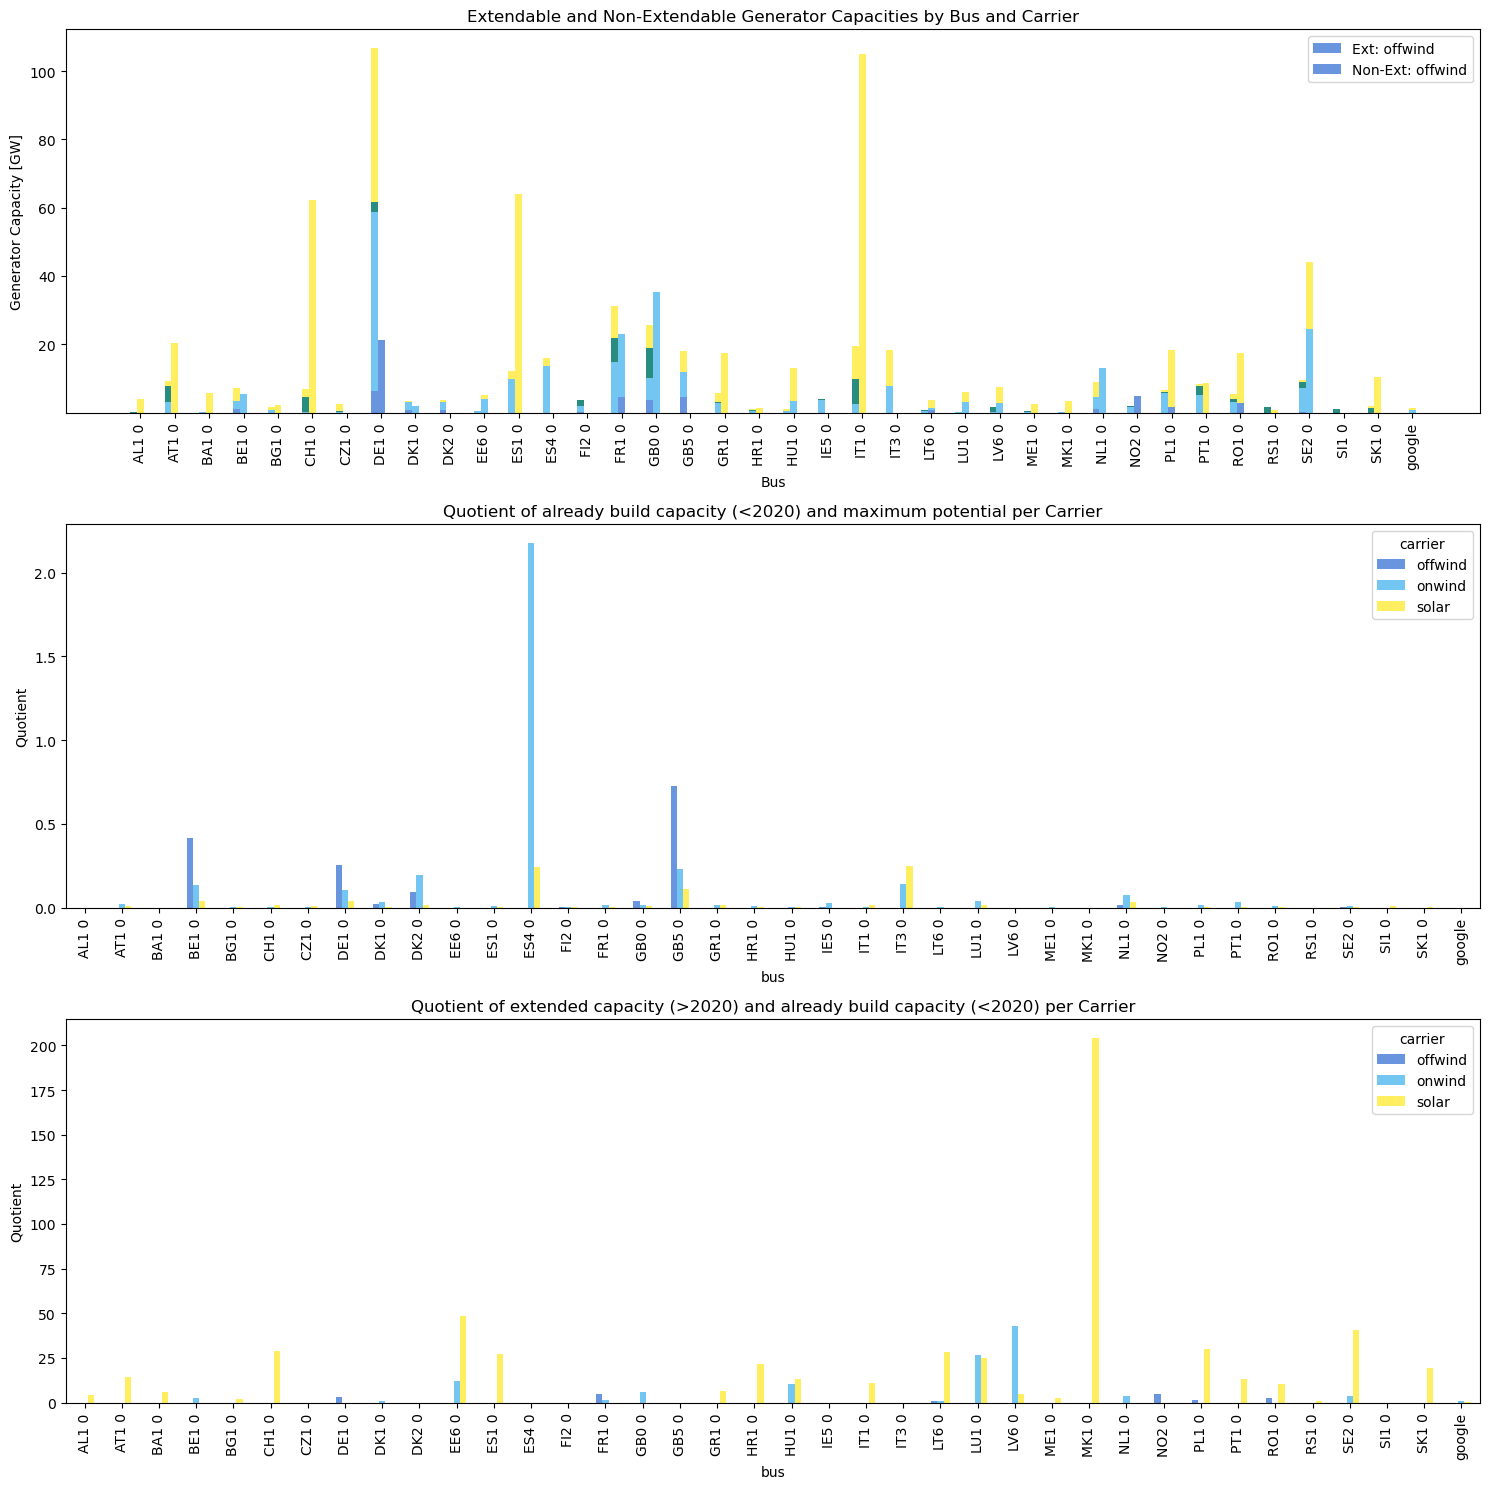

In [27]:
n = pypsa.Network('../results/12_07_validationEU_fix_vre_SARAH/networks/10/2025/IE/p1/2013/res100.nc')
plot_bar_charts_adjacent(n)

INFO:pypsa.io:Imported network res100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
/home/tillotillson/mambaforge/envs/247-env/lib/python3.11/site-packages/matplotlib/transforms.py:2042: RuntimeWarning:

invalid value encountered in scalar add

/home/tillotillson/mambaforge/envs/247-env/lib/python3.11/site-packages/matplotlib/transforms.py:383: RuntimeWarning:

invalid value encountered in scalar subtract



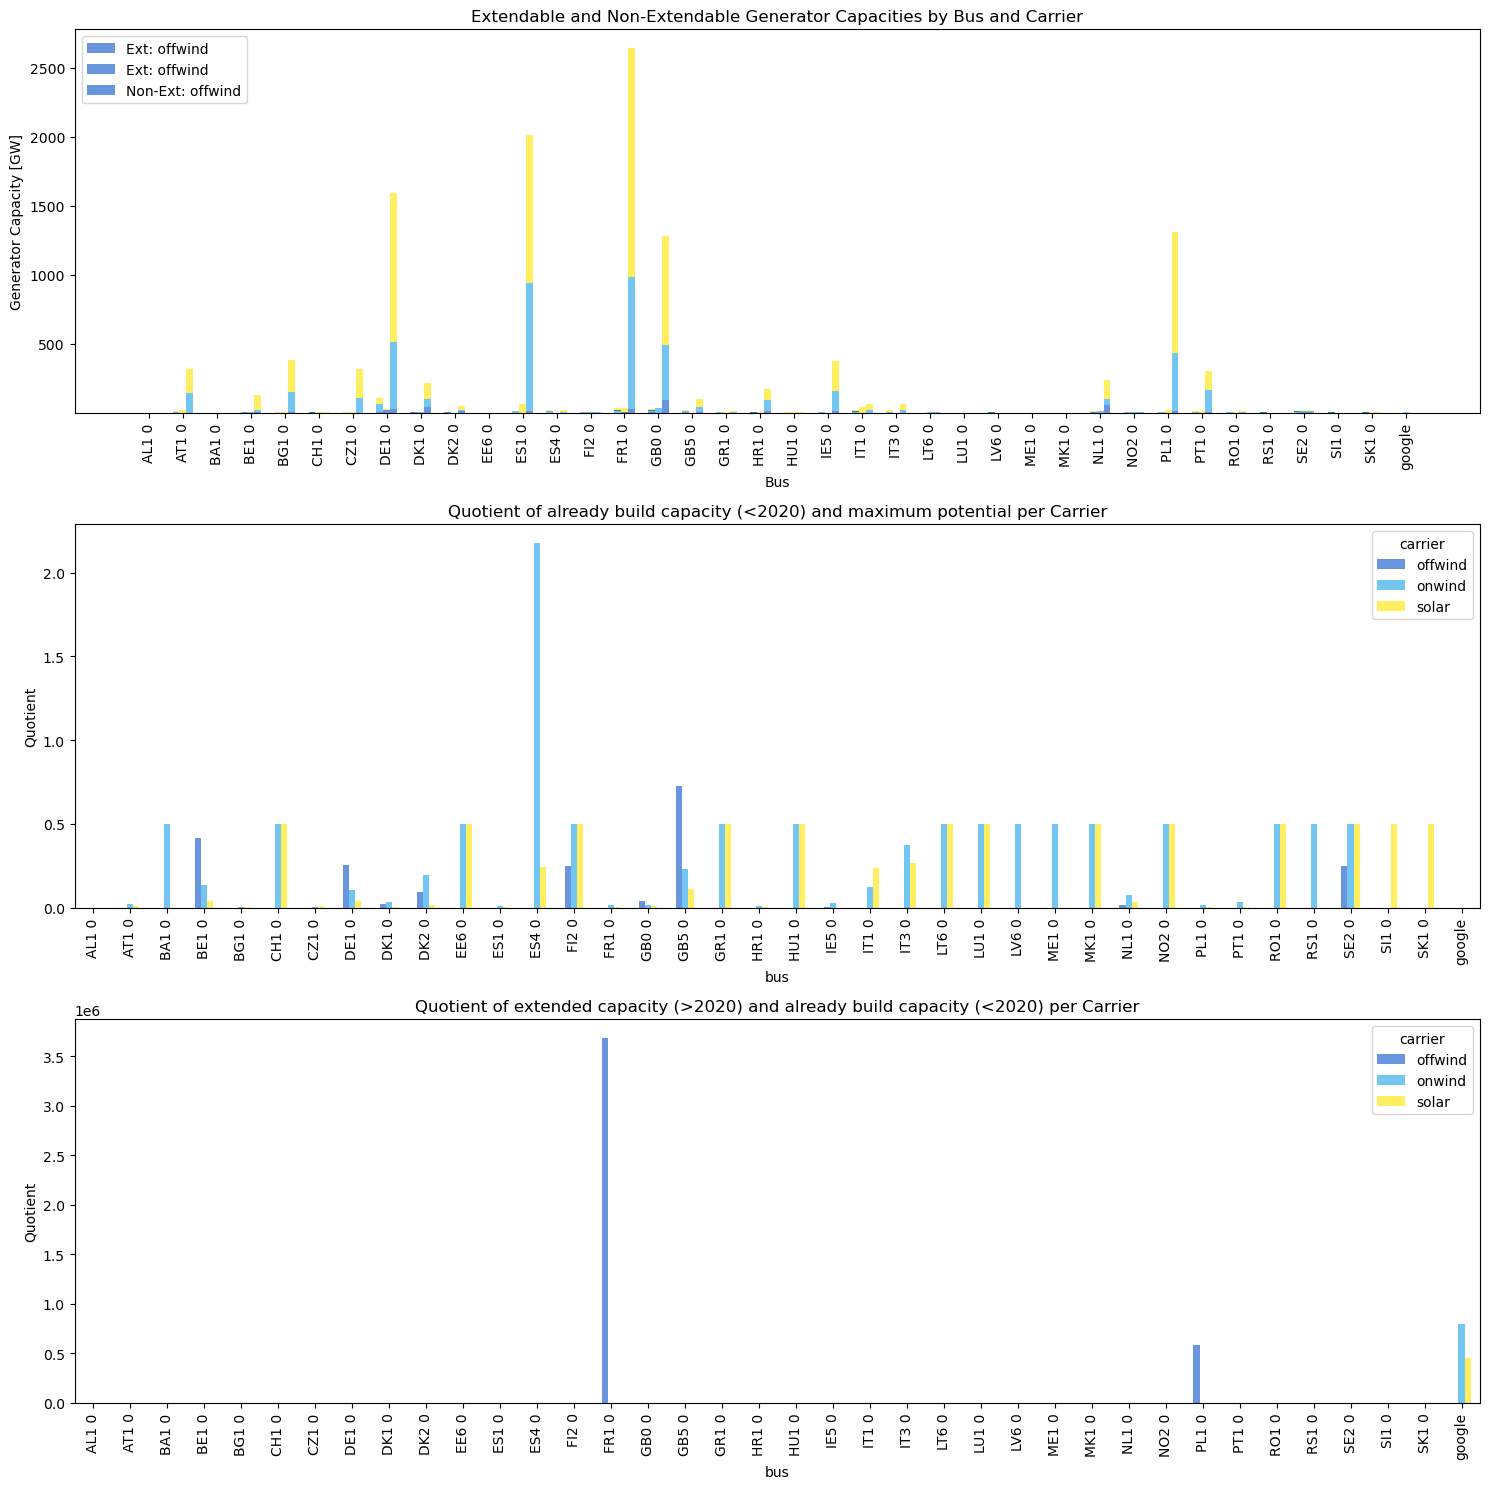

In [32]:
n = pypsa.Network('../results/01_02_validationEU_limitres/networks/10/2025/IE/p1/2013/res100.nc')
plot_bar_charts_adjacent(n)

/tmp/ipykernel_10781/448274757.py:14: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



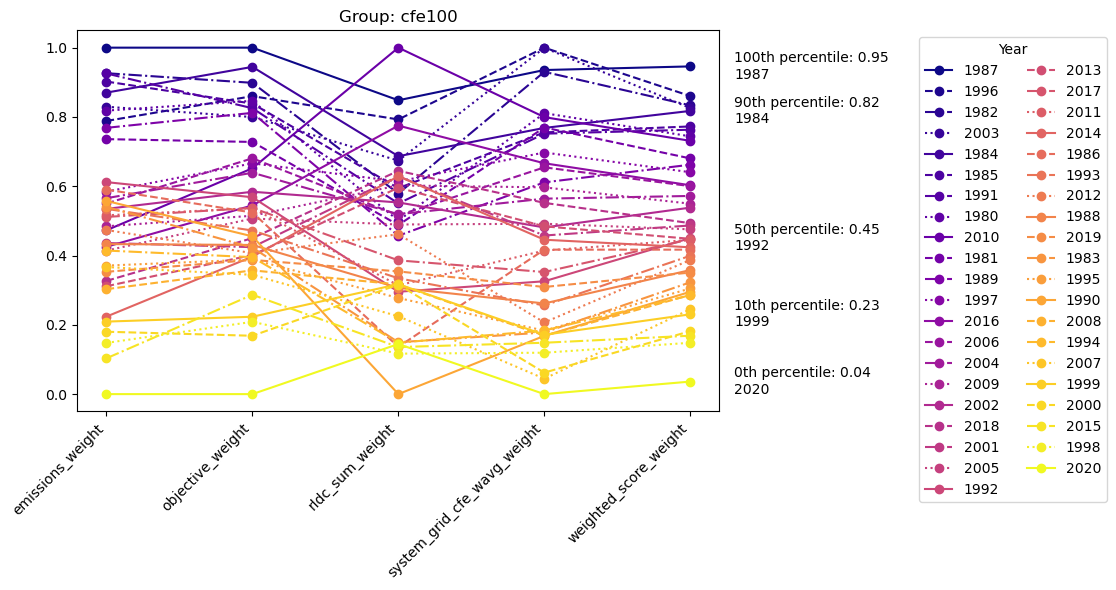

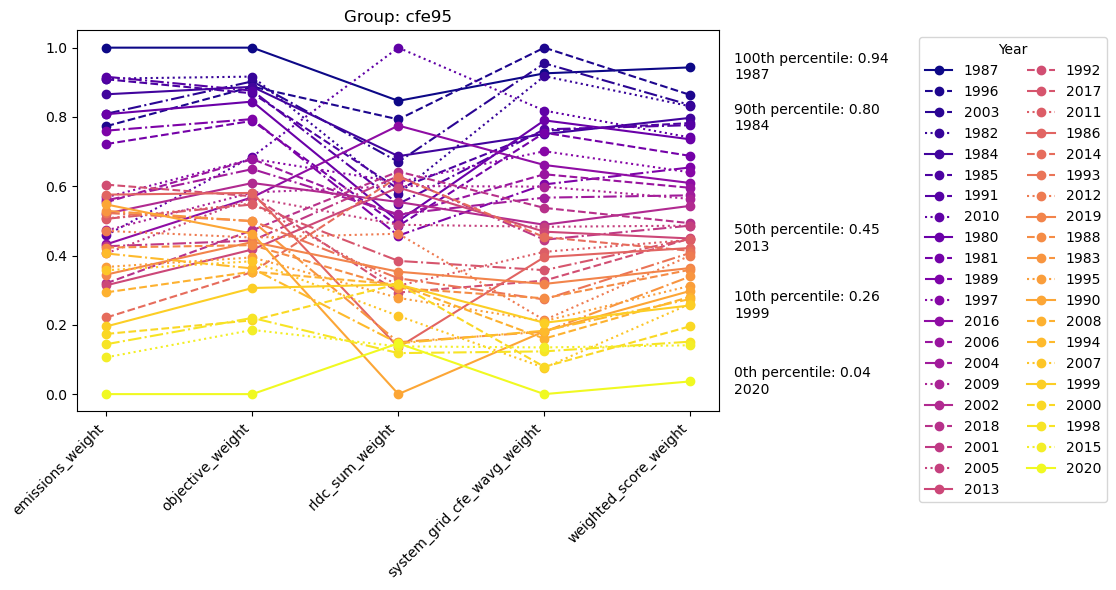

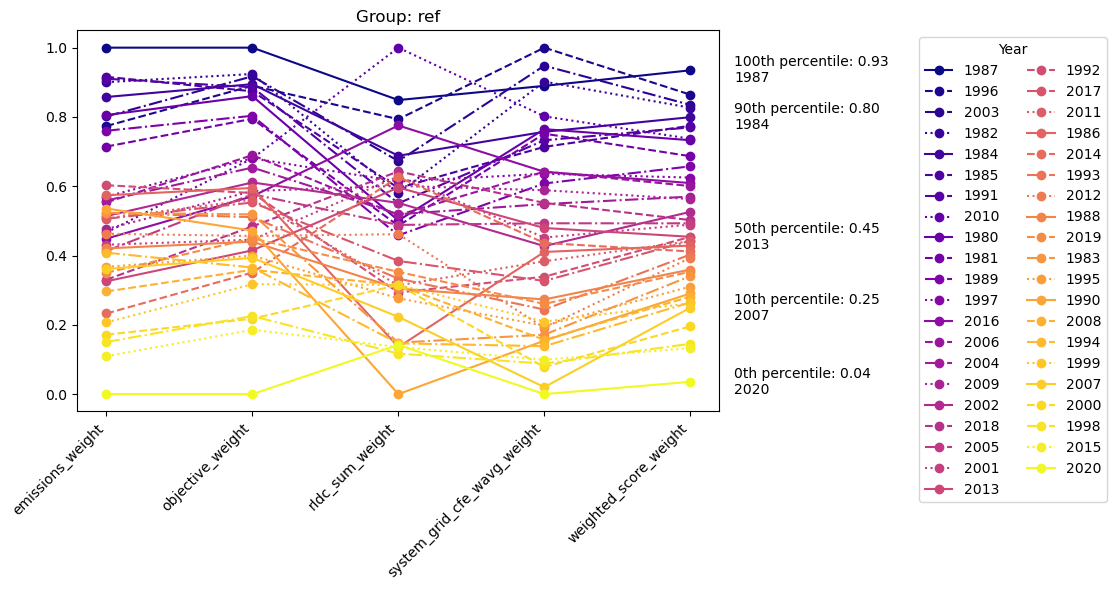

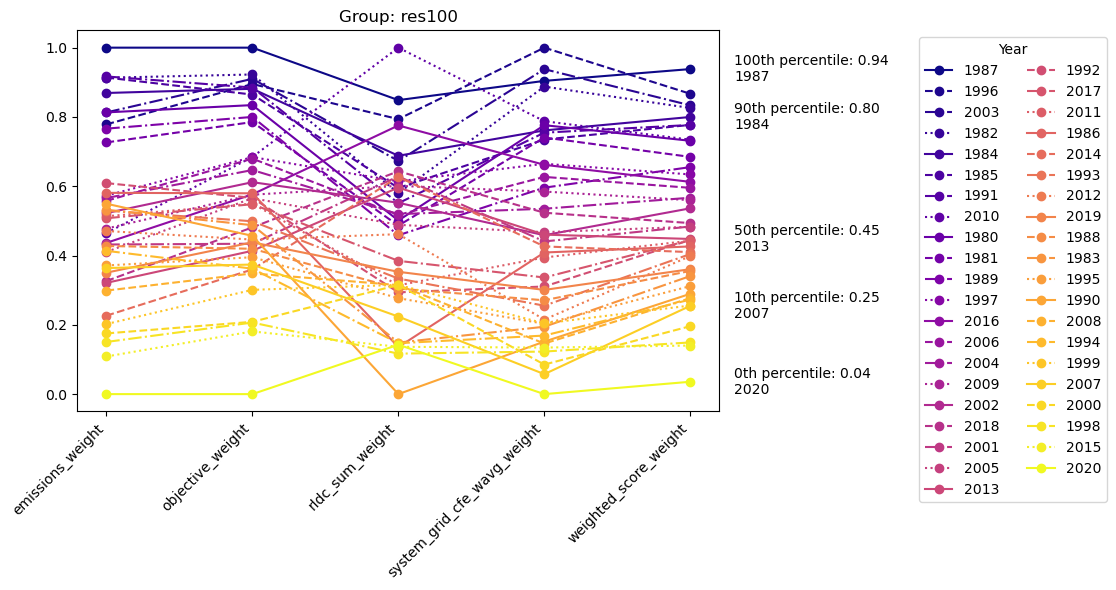

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Read in the dataframe
df = pd.read_csv('../results/02_27-EU/csvs/10/2025/DE/p1/summary_pick.csv')

# Split the dataframe based on the unique values in the first column
groups = df.groupby(df.columns[0])

# Prepare the colormap
total_years = len(df['year'].unique())
colormap = cm.get_cmap('plasma', total_years)  # Get the 'plasma' colormap
normalize = mcolors.Normalize(vmin=0, vmax=total_years-1)

line_styles = ['-', '--', '-.', ':']
markers = ['o'] #, 's', '^', 'D', '*', 'p', 'h']

# Iterate over each group
for group_name, group_df in groups:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Identify columns to plot, excluding the last "result" column
    columns_to_plot = [column for column in group_df.columns if '_weight' in column or '_score' in column]

    # Plot the line plots for each year
    for i, (index, row) in enumerate(group_df.iterrows()):
        # Extract the year and the values for the criteria columns
        year = row['year']
        # Calculate the color
        color = colormap(normalize(i))
        linestyle = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]
        # Plot the criteria performances for this year
        ax.plot(columns_to_plot, row[columns_to_plot], linestyle=linestyle, marker=marker, label=str(year), color=color)

    # Calculate specific percentiles
    percentiles = [100, 90, 50, 10, 0]
    percentile_values = np.percentile(group_df['weighted_score_weight'], percentiles)
    # Highlight and annotate the percentiles
    for percentile, value in zip(percentiles, percentile_values):
        closest_year = group_df.iloc[(group_df['weighted_score_weight']-value).abs().argsort()[:1]]['year'].values[0]
        #ax.axhline(y=value, linestyle='--', color='gray', alpha=0.7)
        ax.text(len(columns_to_plot)-0.7 , value, f'{percentile}th percentile: {value:.2f}\n{closest_year}', verticalalignment='center')
        
    # Add legend and labels
    ax.legend(loc='upper left', bbox_to_anchor=(1.3 ,1), title='Year', ncol=2)
    ax.set_title(f'Group: {group_name}')

    # Improve the layout
    plt.xticks(rotation=45, ha="right")  # Rotate the x-axis labels for better readability
    plt.tight_layout()  # Adjust the layout to make room for the legend and x-axis labels

    # Show the plot
    plt.show()

